In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

# Classifying objects

In the following, we will use the old-school CIFAR-10 dataset that contains low-resolution pictures of objects of 10 categories. This - and other - dataset is available as part of the `torchvision` package, which you should install.

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms, utils
# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it, 
# downloads it if necessary, and adds additional transforms that we 
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


This has now downloaded the images if not already done so - you will notice that this is quite a "hefty" dataset already at 170MB. Now let's download our validation set or test set.

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


## Two-class problem on the GPU

One of the reasons for the success of CNNs has been the realization that computation can be done efficiently on GPUs - originally designed to help with calculation of 3D graphics. 

So, let's push everything onto the GPU now. Let's redefine the same two-class problem as before:

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [7]:
import torch.nn.functional as F

# model with layer 2
class Net2(nn.Module):
    def __init__(self, filter_num = 8, filter_size = 3, padding = 1):
        super().__init__()
        self.filter_num = filter_num; self.filter_size = filter_size; self.padding = padding

        self.conv1 = nn.Conv2d(3, self.filter_num, kernel_size=self.filter_size, padding=self.padding)
        self.conv2 = nn.Conv2d(self.filter_num, 8, kernel_size=self.filter_size, padding=self.padding)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        # print("1", x.size())
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        # print("2", out.size())
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        # print("3", out.size())
        out = out.view(-1, 8 * 8 * 8)
        # print("4", out.size())
        out = torch.tanh(self.fc1(out))
        # print("5", out.size())
        out = self.fc2(out)
        # print("6", out.size())
        return out

In [8]:
import torch.nn.functional as F

# model with layer 3
class Net3(nn.Module):
    def __init__(self, filter_num = 8, filter_size = 3, padding = 1):
        super().__init__()
        self.filter_num = filter_num; self.filter_size = filter_size; self.padding = padding

        self.conv1 = nn.Conv2d(3, self.filter_num, kernel_size=self.filter_size, padding=self.padding)
        self.conv2 = nn.Conv2d(self.filter_num, self.filter_num, kernel_size=self.filter_size, padding=self.padding)
        self.conv3 = nn.Conv2d(self.filter_num, 8, kernel_size=self.filter_size, padding=self.padding)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        # print("1", x.size())
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 1)
        # print("2", out.size())
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        # print("3", out.size())
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        # print("4", out.size())
        out = out.view(-1, 8 * 8 * 8)
        # print("5", out.size())
        out = torch.tanh(self.fc1(out))
        # print("6", out.size())
        out = self.fc2(out)
        # print("7", out.size())
        return out

In [9]:
import torch.nn.functional as F

# model with layer 4
class Net4(nn.Module):
    def __init__(self, filter_num = 8, filter_size = 3, padding = 1):
        super().__init__()
        self.filter_num = filter_num; self.filter_size = filter_size; self.padding = padding

        self.conv1 = nn.Conv2d(3, self.filter_num, kernel_size=self.filter_size, padding=self.padding)
        self.conv2 = nn.Conv2d(self.filter_num, self.filter_num, kernel_size=self.filter_size, padding=self.padding)
        self.conv3 = nn.Conv2d(self.filter_num, self.filter_num, kernel_size=self.filter_size, padding=self.padding)
        self.conv4 = nn.Conv2d(self.filter_num, 8, kernel_size=self.filter_size, padding=self.padding)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        # print("1", x.size())
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 1)
        # print("2", out.size())
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 1)
        # print("3", out.size())
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        # print("4", out.size())
        out = F.max_pool2d(torch.tanh(self.conv4(out)), 2)
        # print("5", out.size())
        out = out.view(-1, 8 * 8 * 8)
        # print("6", out.size())
        out = torch.tanh(self.fc1(out))
        # print("7", out.size())
        out = self.fc2(out)
        # print("8", out.size())
        return out

Now, let's define a device that consists of CUDA (Compute Unified Device Architecture - a standard for general-purpose computing on GPU devices first introduced by NVIDIA in 2007) if supported, or the CPU otherwise.

It is considered good standard to put code similar to this at the beginning of any script so that your code will run no matter if a GPU is present or not.

In [10]:
device = "cuda"
print(f"Training on device {device}.")

Training on device cuda.


We now have to modify our training loop slightly - the only difference is that we will need to tell Pytorch explicitly where the data will need to be processed.

**Note that if data or model reside in different places, Pytorch will produce a run-time error!!**

In [11]:
import datetime 
import time

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    start = time.time()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # put the data onto the correct pytorch calculation device
            imgs = imgs.to(device); labels = labels.to(device)
            # put a batch through the model
            outputs = model(imgs)
            # determine the loss
            loss = loss_fn(outputs, labels)
            # zero the gradients and determine backpropagation
            optimizer.zero_grad()
            loss.backward()
            # do one step of optimization
            optimizer.step()
            # keep track of the loss
            loss_train += loss.item()

        # if epoch == 1 or epoch % 10 == 0:
        #     print('{} Epoch {}, Training loss {}'.format(
        #         datetime.datetime.now(), epoch,
        #         loss_train / len(train_loader)))
    end = time.time() - start
    return end

Now, let's train this (small) convolutional neural network with this training_loop class for 100 epochs:

In [107]:
# example for training_loop
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

# get the model and put it onto the proper device
model = Net4(filter_num = 8, filter_size = 5, padding = 2).to(device)   # filter_size = 3 & padding = 1, filter_size = 5 & padding = 2
# standard optimizer 
optimizer = optim.SGD(model.parameters(), lr=1e-2) 
# classification loss
loss_fn = nn.CrossEntropyLoss()

# go for 100 epochs
training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-06-04 08:39:05.067874 Epoch 1, Training loss 0.6094738184266789
2023-06-04 08:39:10.327094 Epoch 10, Training loss 0.4278000234418614
2023-06-04 08:39:16.336289 Epoch 20, Training loss 0.3214727792960064
2023-06-04 08:39:22.093045 Epoch 30, Training loss 0.28968834459402
2023-06-04 08:39:28.103038 Epoch 40, Training loss 0.25847828340758183
2023-06-04 08:39:33.921315 Epoch 50, Training loss 0.2328325074379611


Compared to our previous version this takes less time - the exact speed-up depends of course on your GPU/CPU combination. 

The validation also needs to change accordingly - here, we will also need to put the data onto the device. Note that the call to the `predicted` variable below also produces a device-fixed output!

In [14]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    value = []
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device); labels = labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        #print("Accuracy {}: {:.2f}".format(name , correct / total))
        value.append(correct / total)
    return value

val_list = validate(model, train_loader, val_loader)

# "for loop" to compare 24 combination

In [15]:
from tqdm import tqdm

In [17]:
def return_result(model, train_loader, val_loader):
    model = model
    optimizer = optim.SGD(model.parameters(), lr=1e-2); loss_fn = nn.CrossEntropyLoss()
    train_time = training_loop(n_epochs = 50, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader)
    val_list = validate(model, train_loader, val_loader)
    return train_time, val_list

In [20]:
filter_num = [8, 16, 32, 64]; filter_size = [3, 5]
layer_N = []; train_ACC = []; test_ACC = []; filter_N = []; filter_S = []
time_list = []; seed = []

In [21]:
for N in tqdm(range(42, 52)):
    torch.manual_seed(42)
    train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
    val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
    for filter_n in filter_num:
        for filter_s in filter_size:
            if filter_s == 3: padding = 1
            else: padding = 2

            # layer 2
            model = Net2(filter_num = filter_n, filter_size = filter_s, padding = padding).to(device)
            train_time, val_list = return_result(model, train_loader, val_loader)
            seed.append(N); layer_N.append(2); train_ACC.append(val_list[0]); test_ACC.append(val_list[1]); time_list.append(train_time); filter_N.append(filter_n); filter_S.append(filter_s)

            # layer 3
            model = Net3(filter_num = filter_n, filter_size = filter_s, padding = padding).to(device)
            train_time, val_list = return_result(model, train_loader, val_loader)
            seed.append(N); layer_N.append(3); train_ACC.append(val_list[0]); test_ACC.append(val_list[1]); time_list.append(train_time); filter_N.append(filter_n); filter_S.append(filter_s)

            # layer 4
            model = Net4(filter_num = filter_n, filter_size = filter_s, padding = padding).to(device)
            train_time, val_list = return_result(model, train_loader, val_loader)
            seed.append(N); layer_N.append(4); train_ACC.append(val_list[0]); test_ACC.append(val_list[1]); time_list.append(train_time); filter_N.append(filter_n); filter_S.append(filter_s)

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [2:50:47<00:00, 1024.78s/it]


In [22]:
import pandas as pd

result = pd.DataFrame(None)
result['seed'] = seed
result['layer number'] = layer_N
result['filter number'] = filter_N
result['filter size'] = filter_S
result['train accuracy'] = train_ACC
result['test accuracy'] = test_ACC
result['time performance'] = time_list

In [23]:
result.to_csv("result.csv", index = False)

# Visualization


3d bar plot
- train ACC
- test ACC
- timing performance

In [1]:
from IPython.display import Image

## result

Interpretation:
- The x-axis is the number of filters, the y-axis is the filter size, and the z-axis is the train accuracy, test accuracy, and timing performance from the left, respectively. The closer the color of the triangle is to red, the higher the z-axis value.
- From the train accuracy on the left, it can be seen that layer 2, layer 3, and layer 4 all achieved the highest performance when the filter size was 5. In the case of filter number, although there is a difference in ranking, higher performance was achieved when there were many filters at 32,64.
- The test accuracy result shows a different tendency from the train accuracy result. The filter size of the model with the highest performance is 5 as the result of the train, but if the filter size is 3, the performance of the models is different from the ranking in the train. In the train result, when the filter size was 3, the performance tended to increase as the filter number increased, but in the test result, this trend was not shown except for layer 2. In layer 3 and layer 4, it can be seen that the test accuracy of the model with small filter size and small filter number is higher than that of the train accuracy.
- The rightmost graph shows timing performance. First, it may be seen that the lower the graph, that is, as the number of layers increases, the time required for training increases. Comparing the timing performance among models with the same number of layers, it may be seen that as the filter number is larger and the filter size is larger, the time required for the train is increased. One thing to note is that the timing performance is highly volatile when the number of layers is small, so the timing performance of models with a filter size of 3 in layer 2 is very large compared to other models.
- Both train and test accursions are not highly volatile, so the error bar is not easily visible. The detailed sd can be calculated from the result attached together.

![nn](그림1.png)

## code

In [105]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import numpy as np

In [106]:
result = pd.read_csv('result.csv')

df = result.copy()
df = df.drop(['seed'], axis = 1)

df.head(2)

layer number  filter number  filter size  train accuracy  test accuracy  \
0             2              8            3          0.8786         0.8710   
1             3              8            3          0.8873         0.8805   

   time performance  
0         20.543176  
1         25.689296

### Train Accuracy

In [107]:
df_edit = df[['layer number', 'filter number', 'filter size', 'train accuracy']].reset_index(drop = True)

ddd = df_edit.groupby(['layer number', 'filter number', 'filter size'])
dd2 = ddd.agg(['mean', 'std']).reset_index(drop = False)

dd2.columns.droplevel()
dd2.columns = ['layer number', 'filter number', 'filter size', 'mean', 'std']

dd2_l2 = dd2[dd2['layer number'] == 2].reset_index(drop = True)
dd2_l3 = dd2[dd2['layer number'] == 3].reset_index(drop = True)
dd2_l4 = dd2[dd2['layer number'] == 4].reset_index(drop = True)

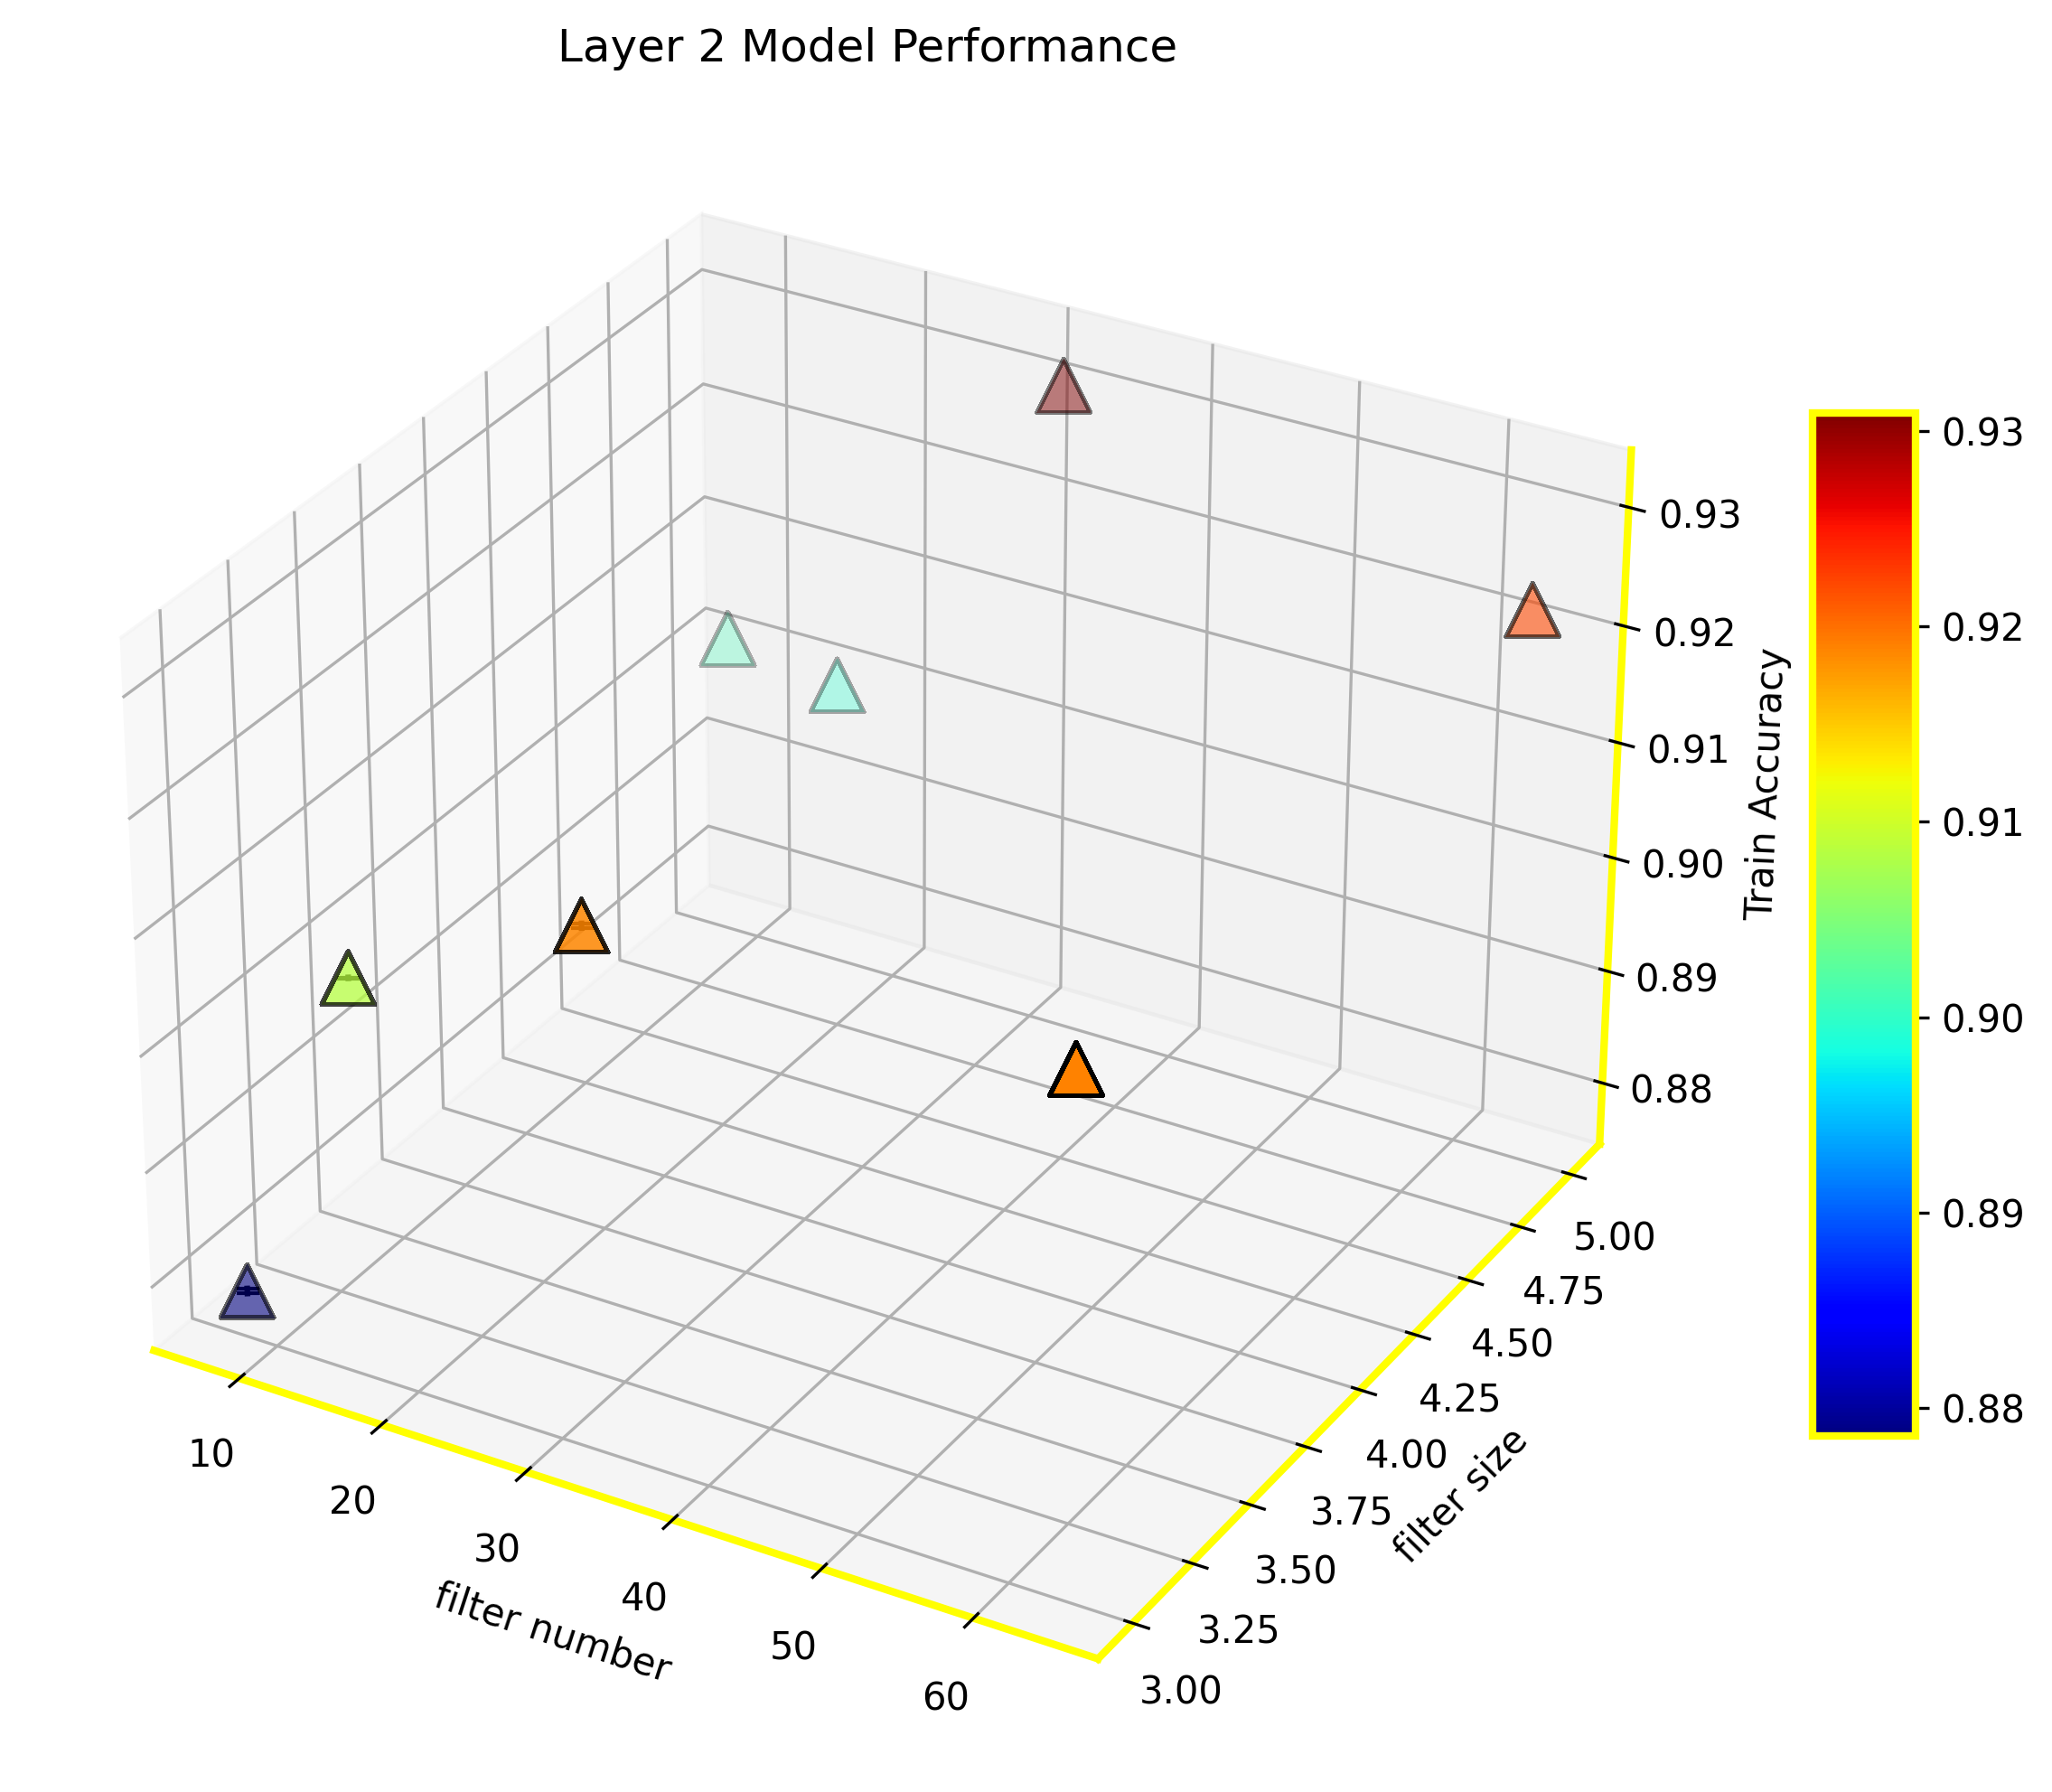

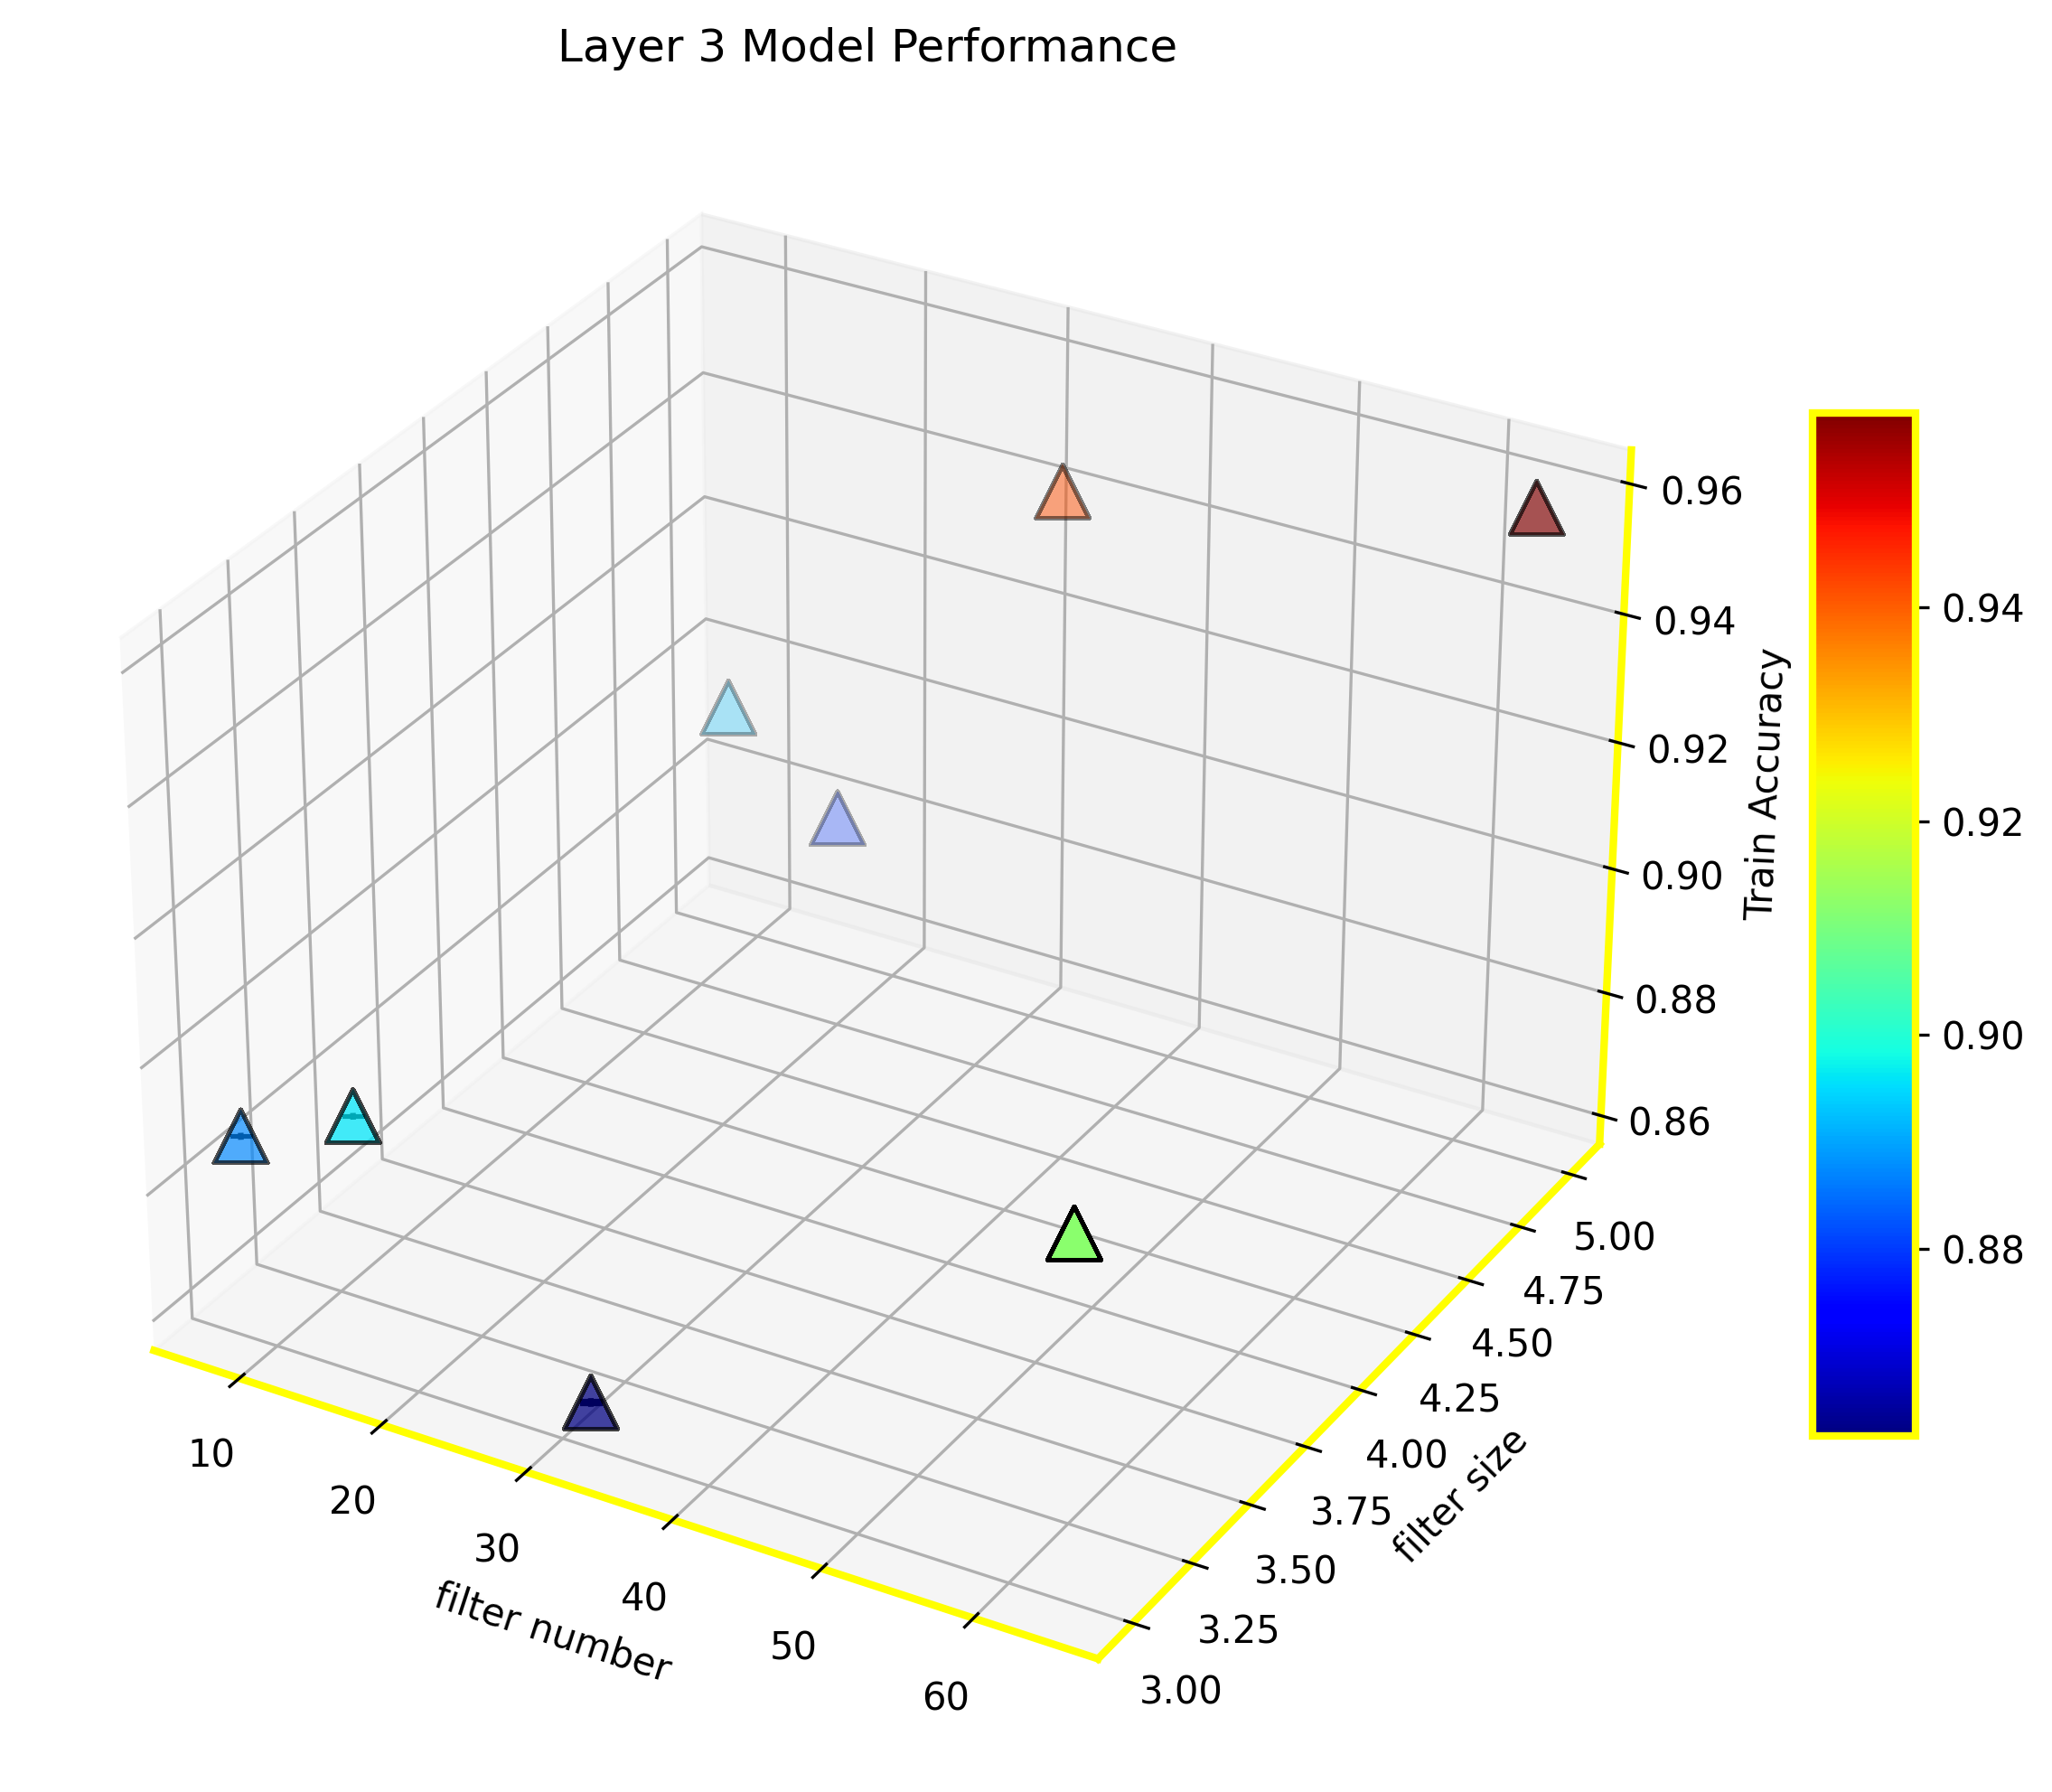

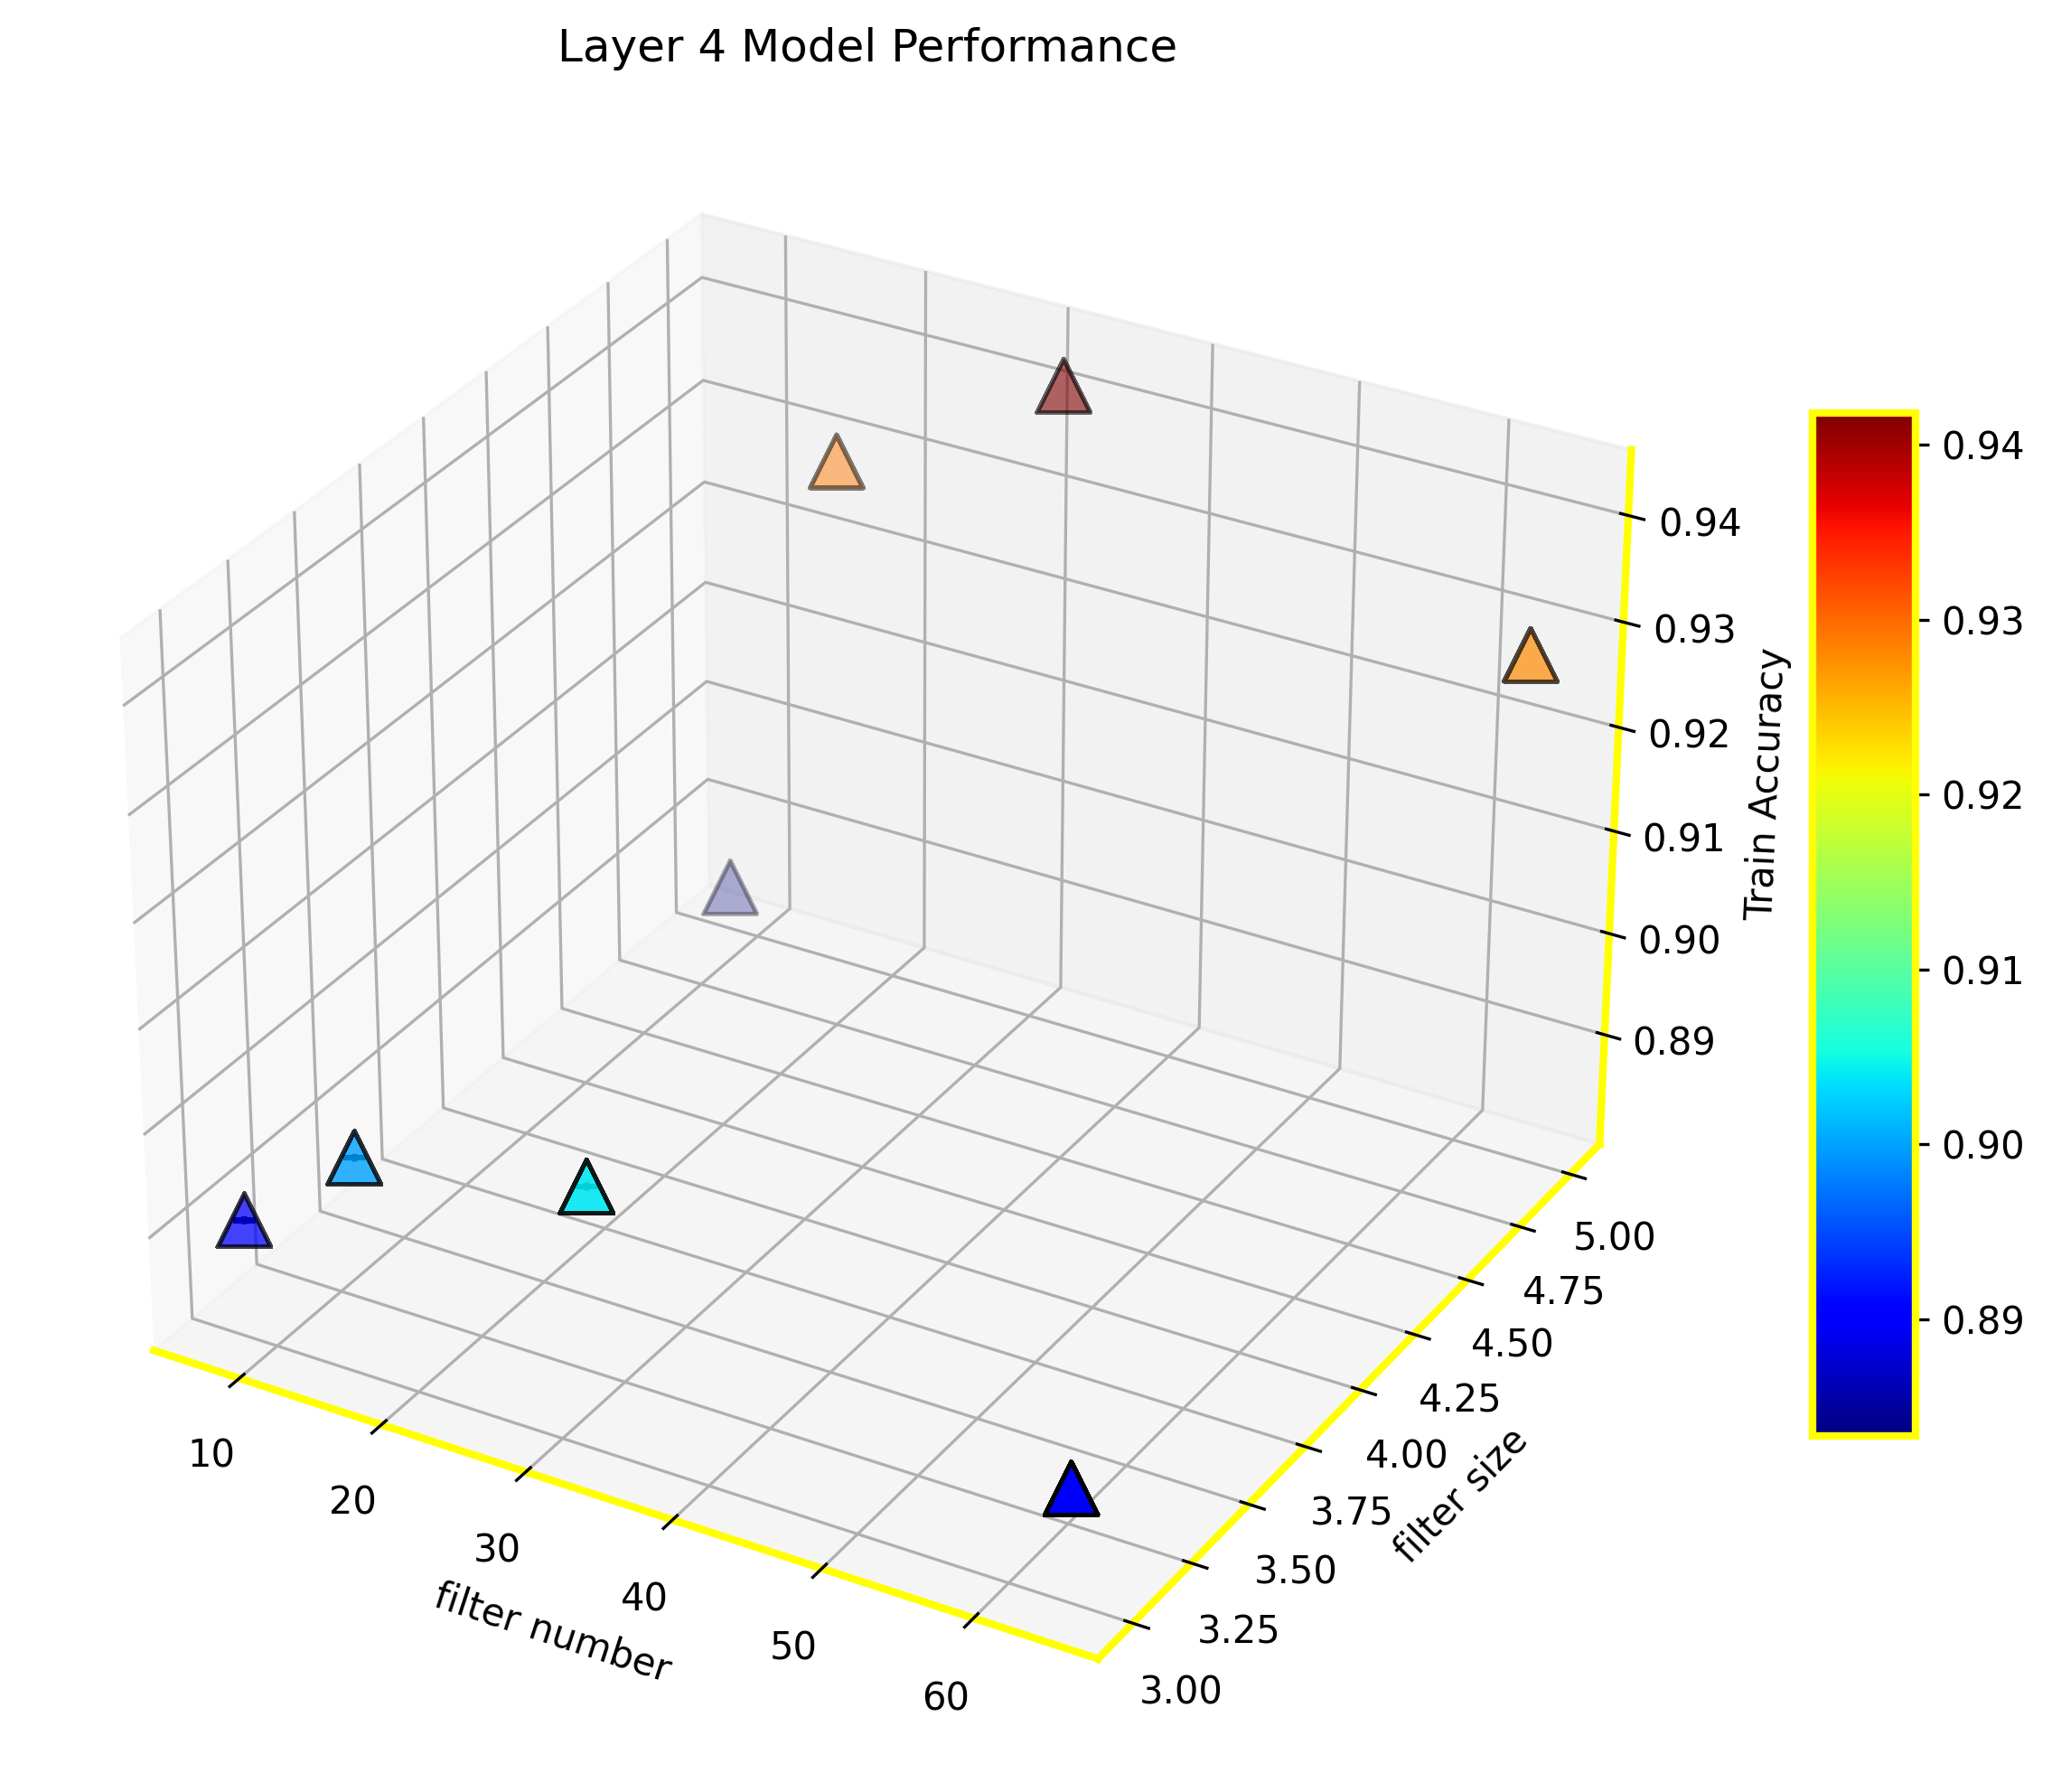

In [108]:
j = 2
for df_ in [dd2_l2, dd2_l3, dd2_l4]:
    #data
    fx = (8, 16, 32, 64)
    fy = (3, 5)
    z = [df_[df_['filter size'] == 3]['mean'],  # Pay attention to the formatting here!
         df_[df_['filter size'] == 5]['mean']]


    x, y = np.meshgrid(fx, fy)


    #error data
    zerror = [df_[df_['filter size'] == 3]['std'],  # Pay attention to the formatting here!
              df_[df_['filter size'] == 5]['std']]



    #plot points
    fig = plt.figure(figsize = (10,10), dpi = 300)
    ax = fig.gca(projection='3d')
    surf=ax.scatter3D(x, y, z,  c=z, cmap="jet", s=200, edgecolors="black", linewidth=1, marker= "^", antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)

    ax.set_xlabel('filter number')
    ax.set_ylabel('filter size')
    ax.set_zlabel('Train Accuracy')
    ax.set_title('Layer {} Model Performance'.format(j))
    ax.view_init(30, 300)
    j += 1

    #plot errorbars
    for i in np.arange(0, len(fy)-1):  # Lines were modified here!
        for xval, yval, zval, zerr in zip(x[i], y[i], z[i], zerror[i]):
            ax.plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='k')
    plt.show()

### Test Accuracy

In [109]:
df_edit = df[['layer number', 'filter number', 'filter size', 'test accuracy']].reset_index(drop = True)

ddd = df_edit.groupby(['layer number', 'filter number', 'filter size'])
dd2 = ddd.agg(['mean', 'std']).reset_index(drop = False)

dd2.columns.droplevel()
dd2.columns = ['layer number', 'filter number', 'filter size', 'mean', 'std']

dd2_l2 = dd2[dd2['layer number'] == 2].reset_index(drop = True)
dd2_l3 = dd2[dd2['layer number'] == 3].reset_index(drop = True)
dd2_l4 = dd2[dd2['layer number'] == 4].reset_index(drop = True)

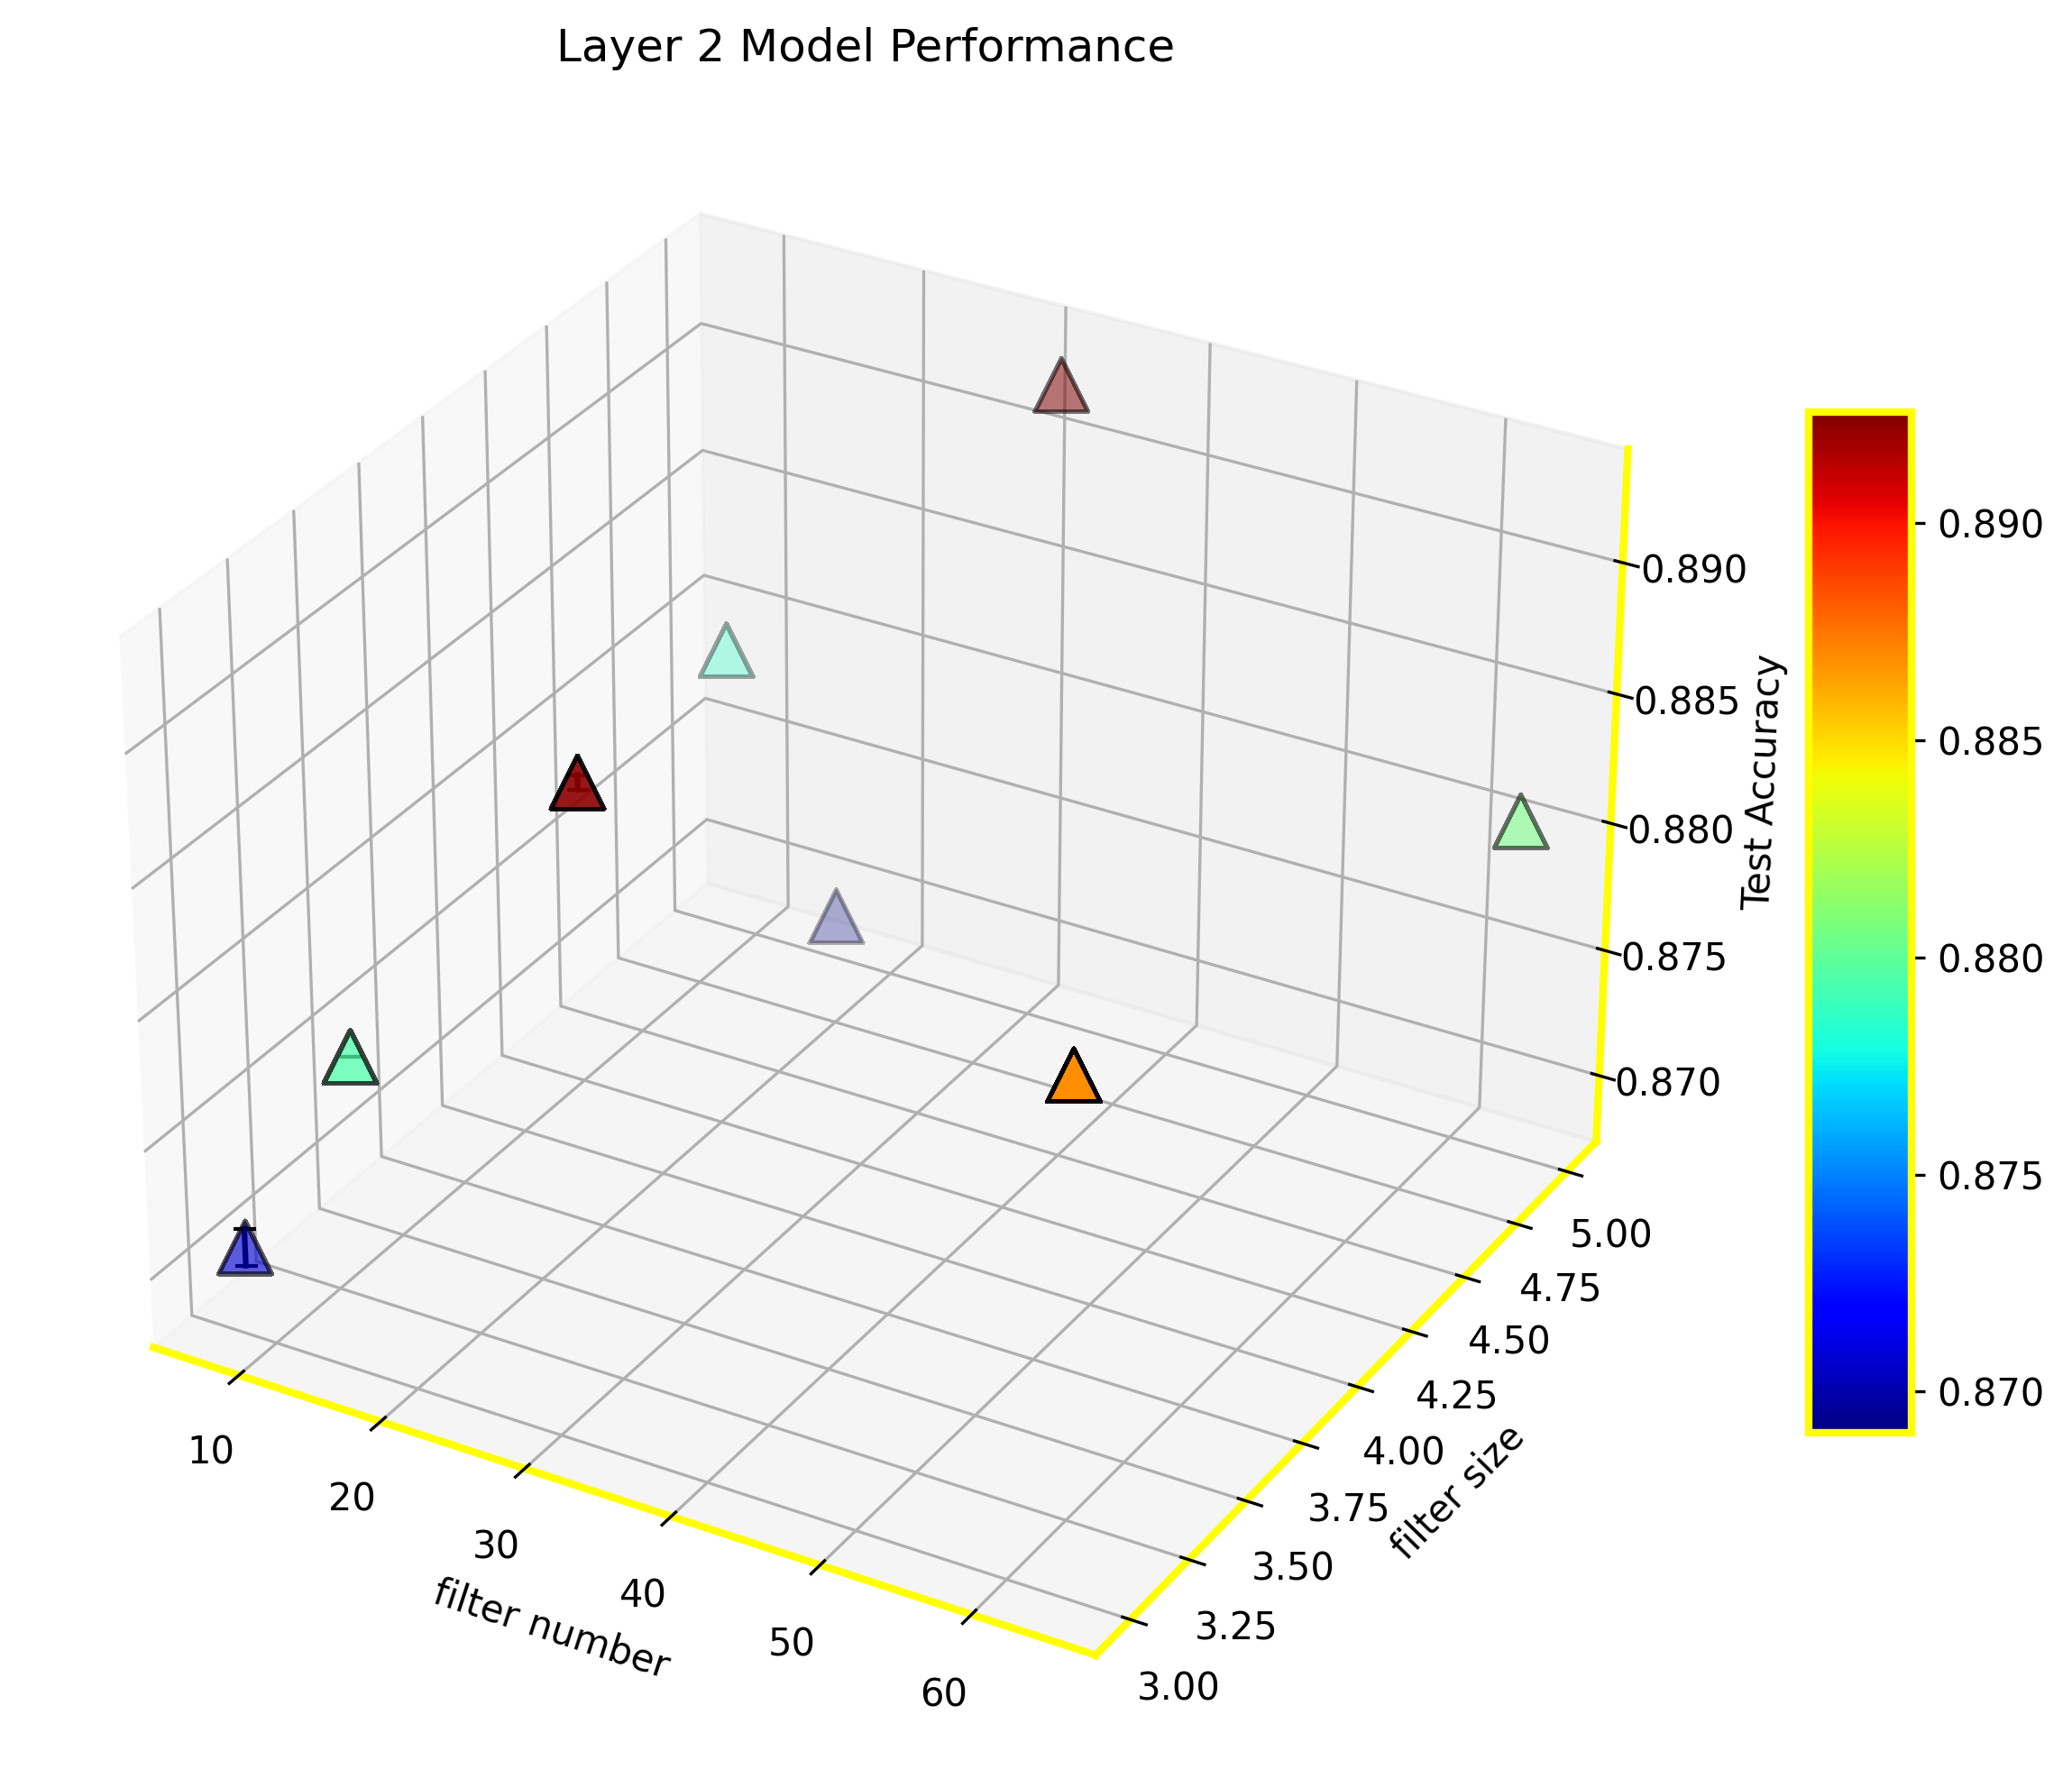

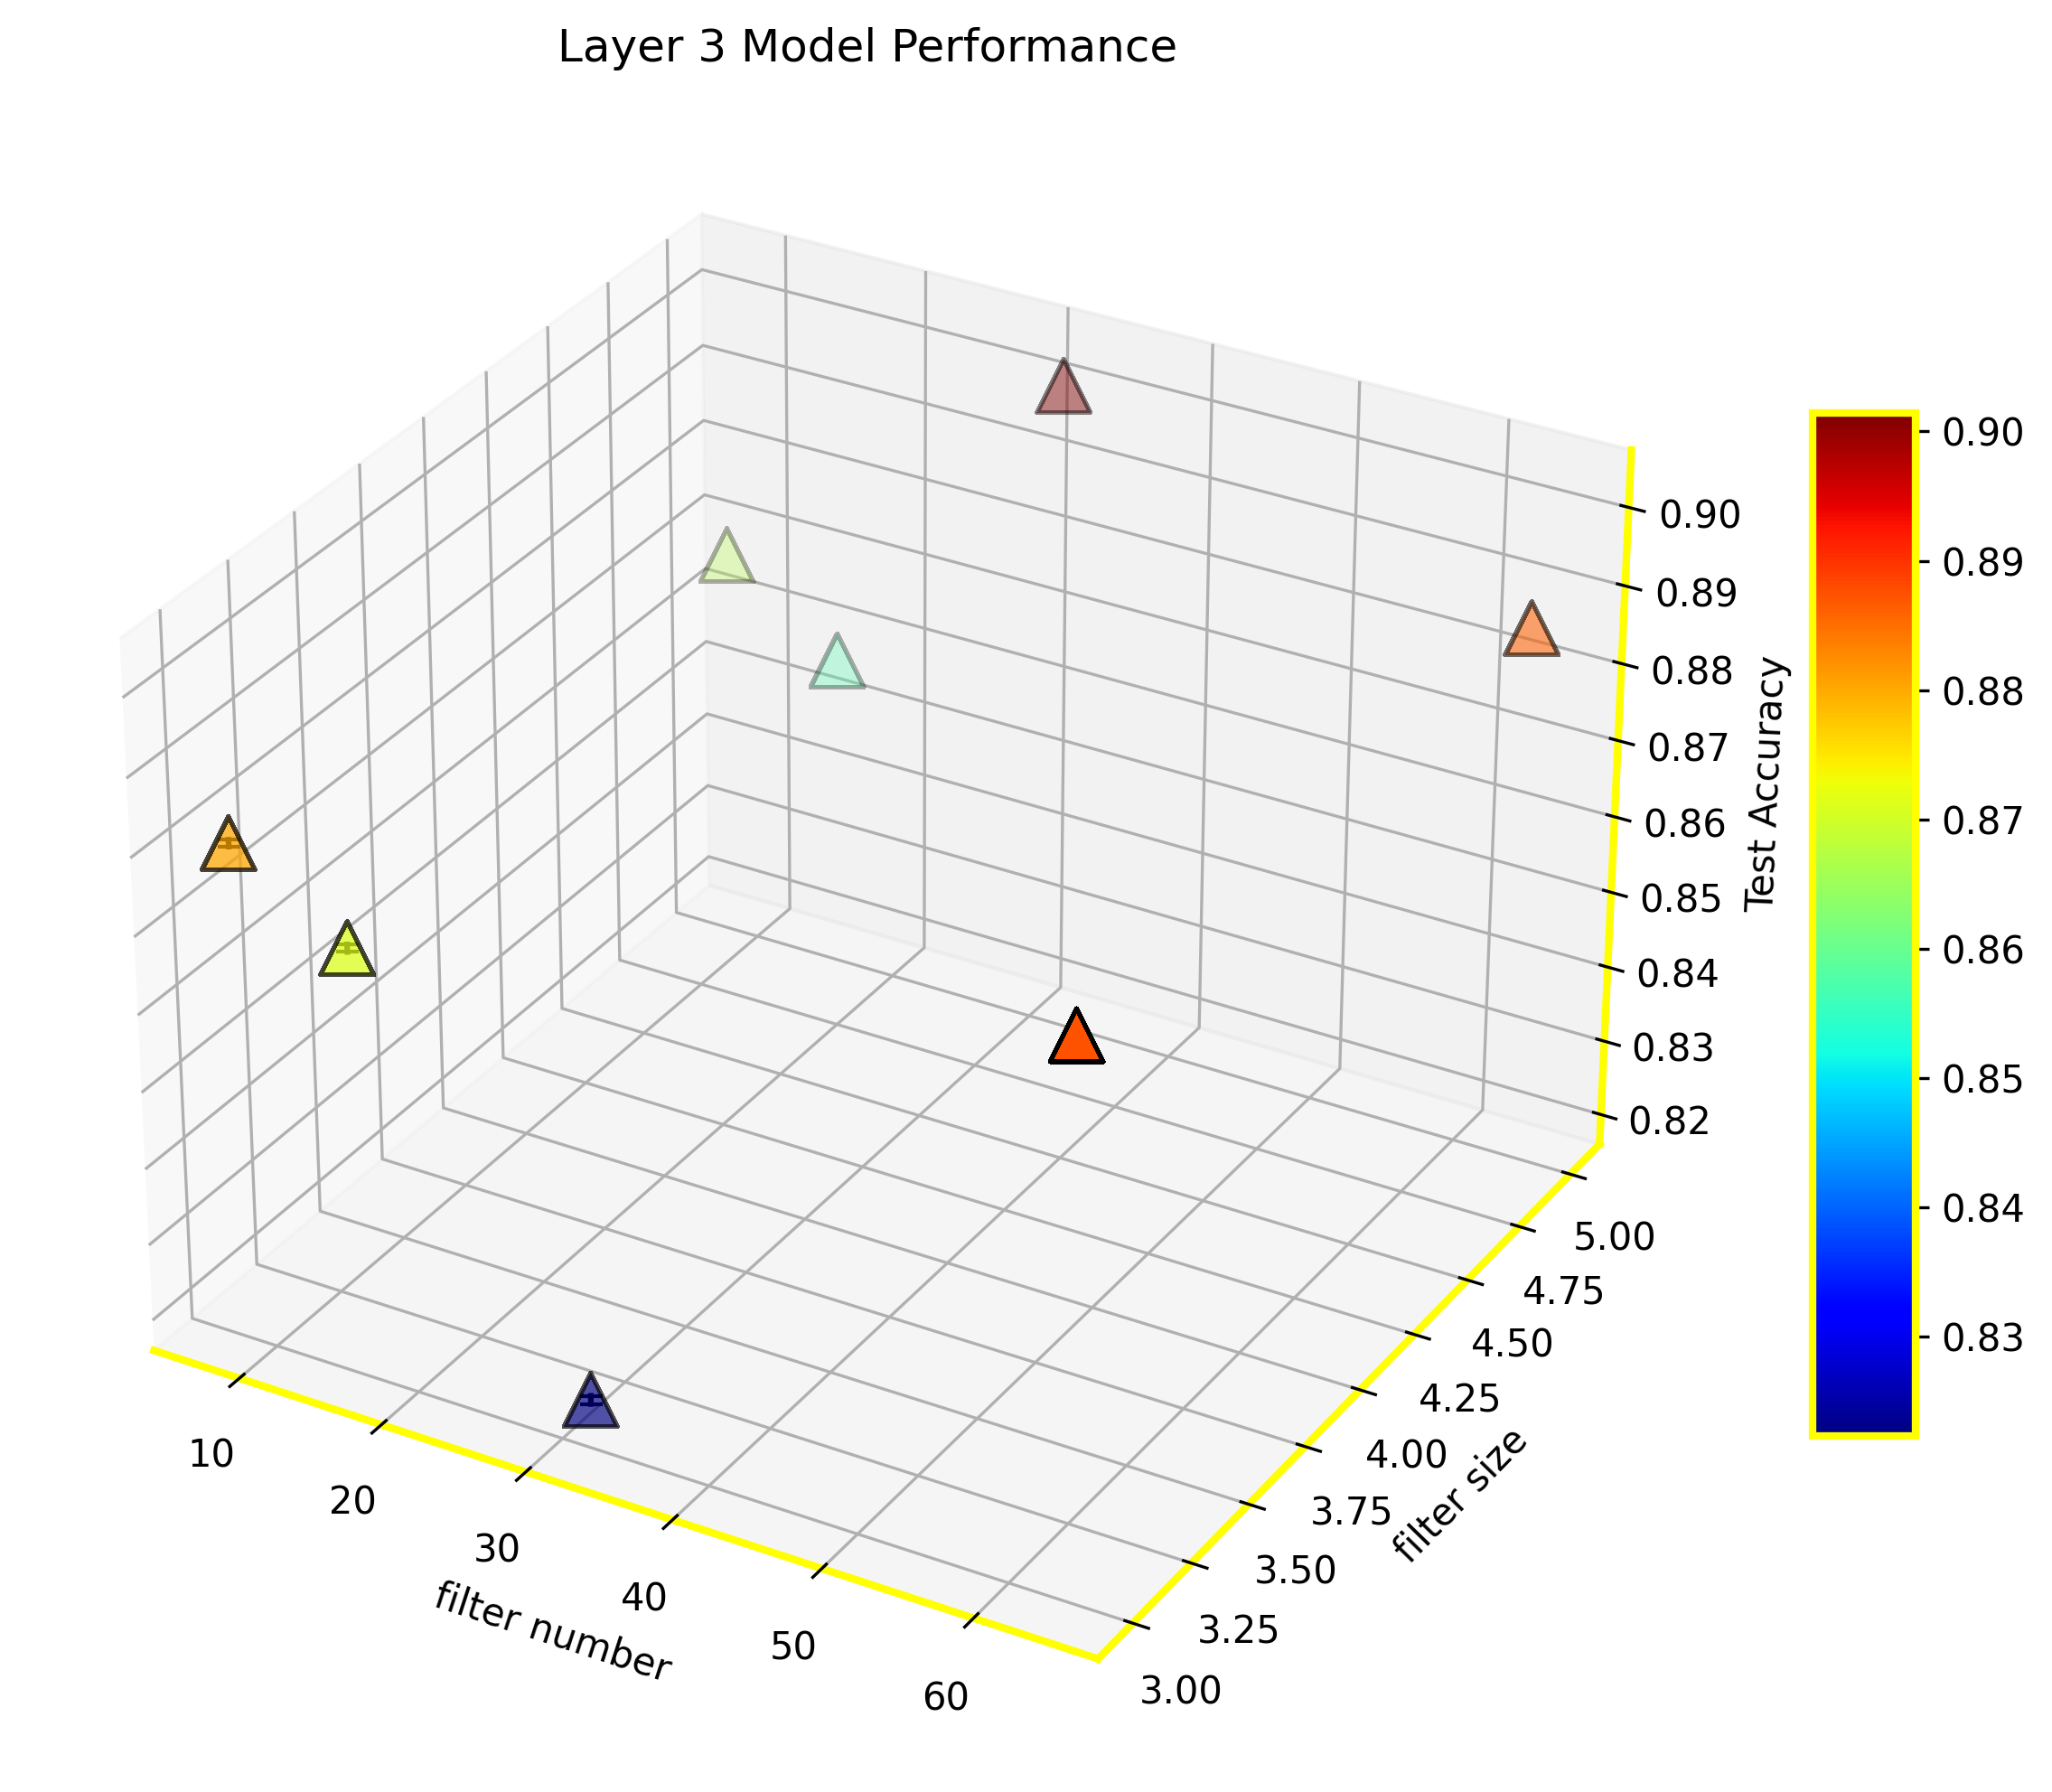

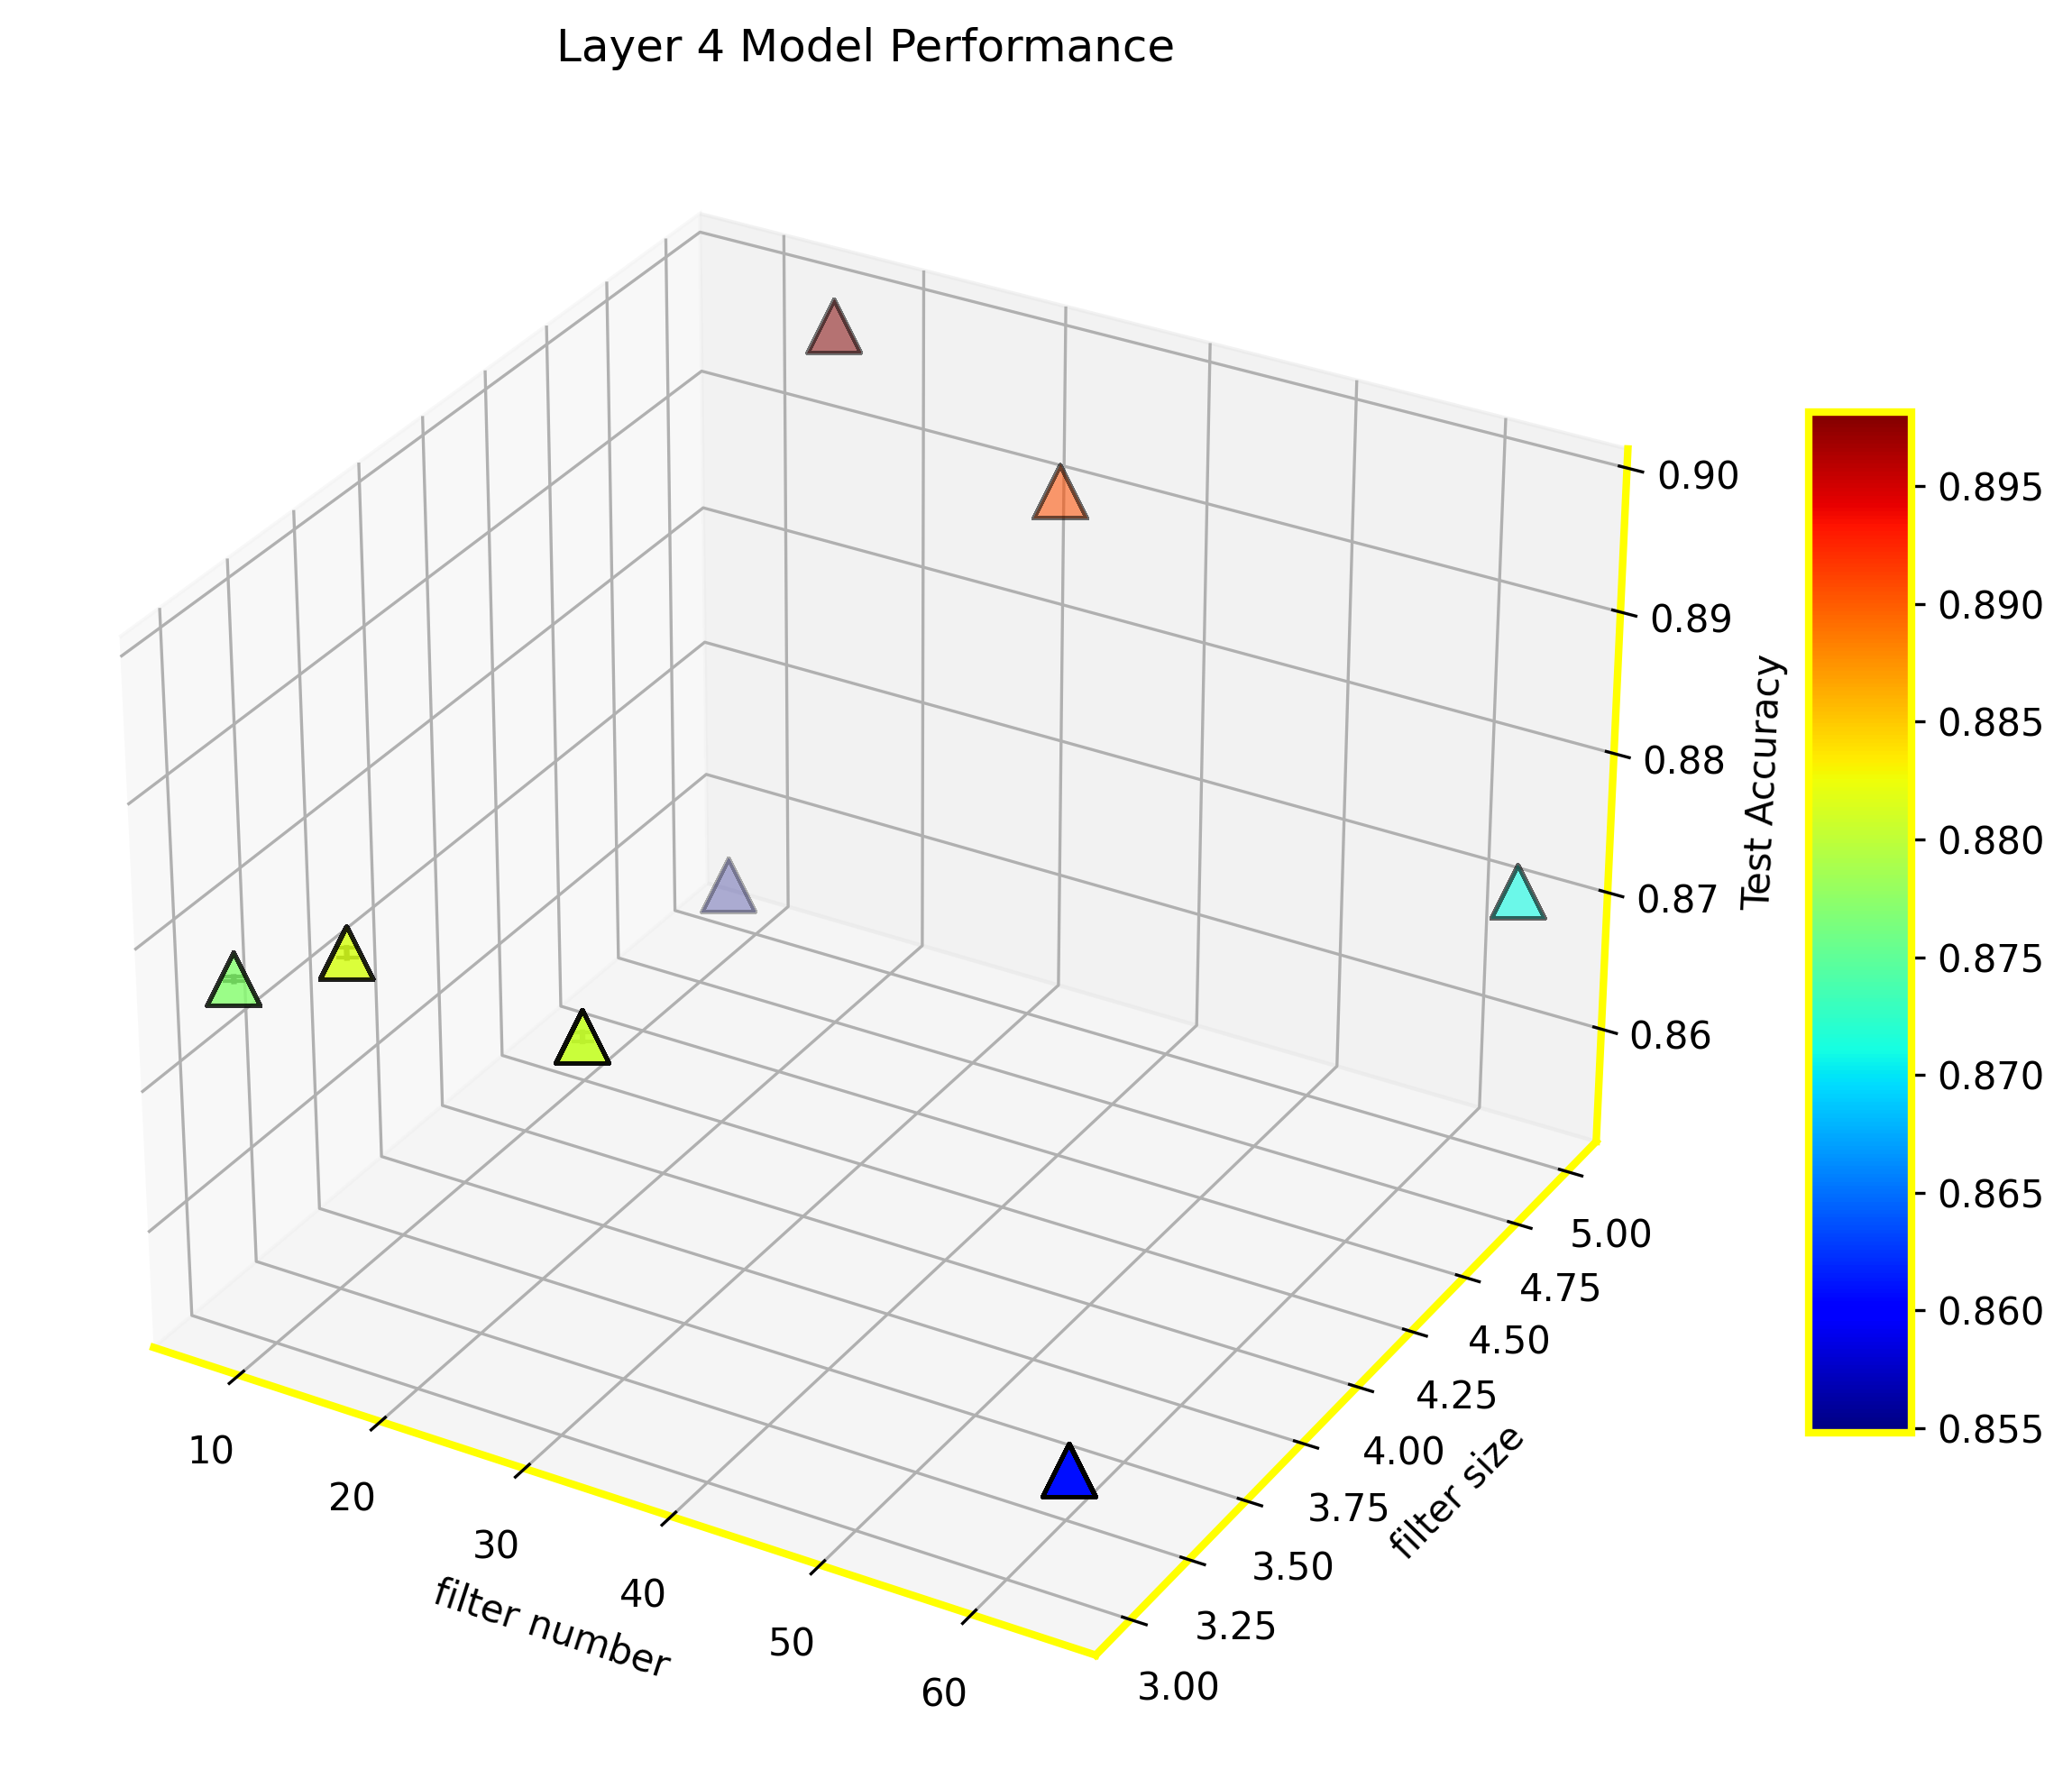

In [110]:
j = 2
for df_ in [dd2_l2, dd2_l3, dd2_l4]:
    #data
    fx = (8, 16, 32, 64)
    fy = (3, 5)
    z = [df_[df_['filter size'] == 3]['mean'],  # Pay attention to the formatting here!
         df_[df_['filter size'] == 5]['mean']]


    x, y = np.meshgrid(fx, fy)


    #error data
    zerror = [df_[df_['filter size'] == 3]['std'],  # Pay attention to the formatting here!
              df_[df_['filter size'] == 5]['std']]



    #plot points
    fig = plt.figure(figsize = (10,10), dpi = 300)
    ax = fig.gca(projection='3d')
    surf=ax.scatter3D(x, y, z,  c=z, cmap="jet", s=200, edgecolors="black", linewidth=1, marker= "^", antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)

    ax.set_xlabel('filter number')
    ax.set_ylabel('filter size')
    ax.set_zlabel('Test Accuracy')
    ax.set_title('Layer {} Model Performance'.format(j))
    ax.view_init(30, 300)
    j += 1

    #plot errorbars
    for i in np.arange(0, len(fy)-1):  # Lines were modified here!
        for xval, yval, zval, zerr in zip(x[i], y[i], z[i], zerror[i]):
            ax.plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='k')
    plt.show()

### Timing performance

In [116]:
df_edit = df[['layer number', 'filter number', 'filter size', 'time performance']].reset_index(drop = True)

ddd = df_edit.groupby(['layer number', 'filter number', 'filter size'])
dd2 = ddd.agg(['mean', 'std']).reset_index(drop = False)

dd2.columns.droplevel()
dd2.columns = ['layer number', 'filter number', 'filter size', 'mean', 'std']

dd2_l2 = dd2[dd2['layer number'] == 2].reset_index(drop = True)
dd2_l3 = dd2[dd2['layer number'] == 3].reset_index(drop = True)
dd2_l4 = dd2[dd2['layer number'] == 4].reset_index(drop = True)

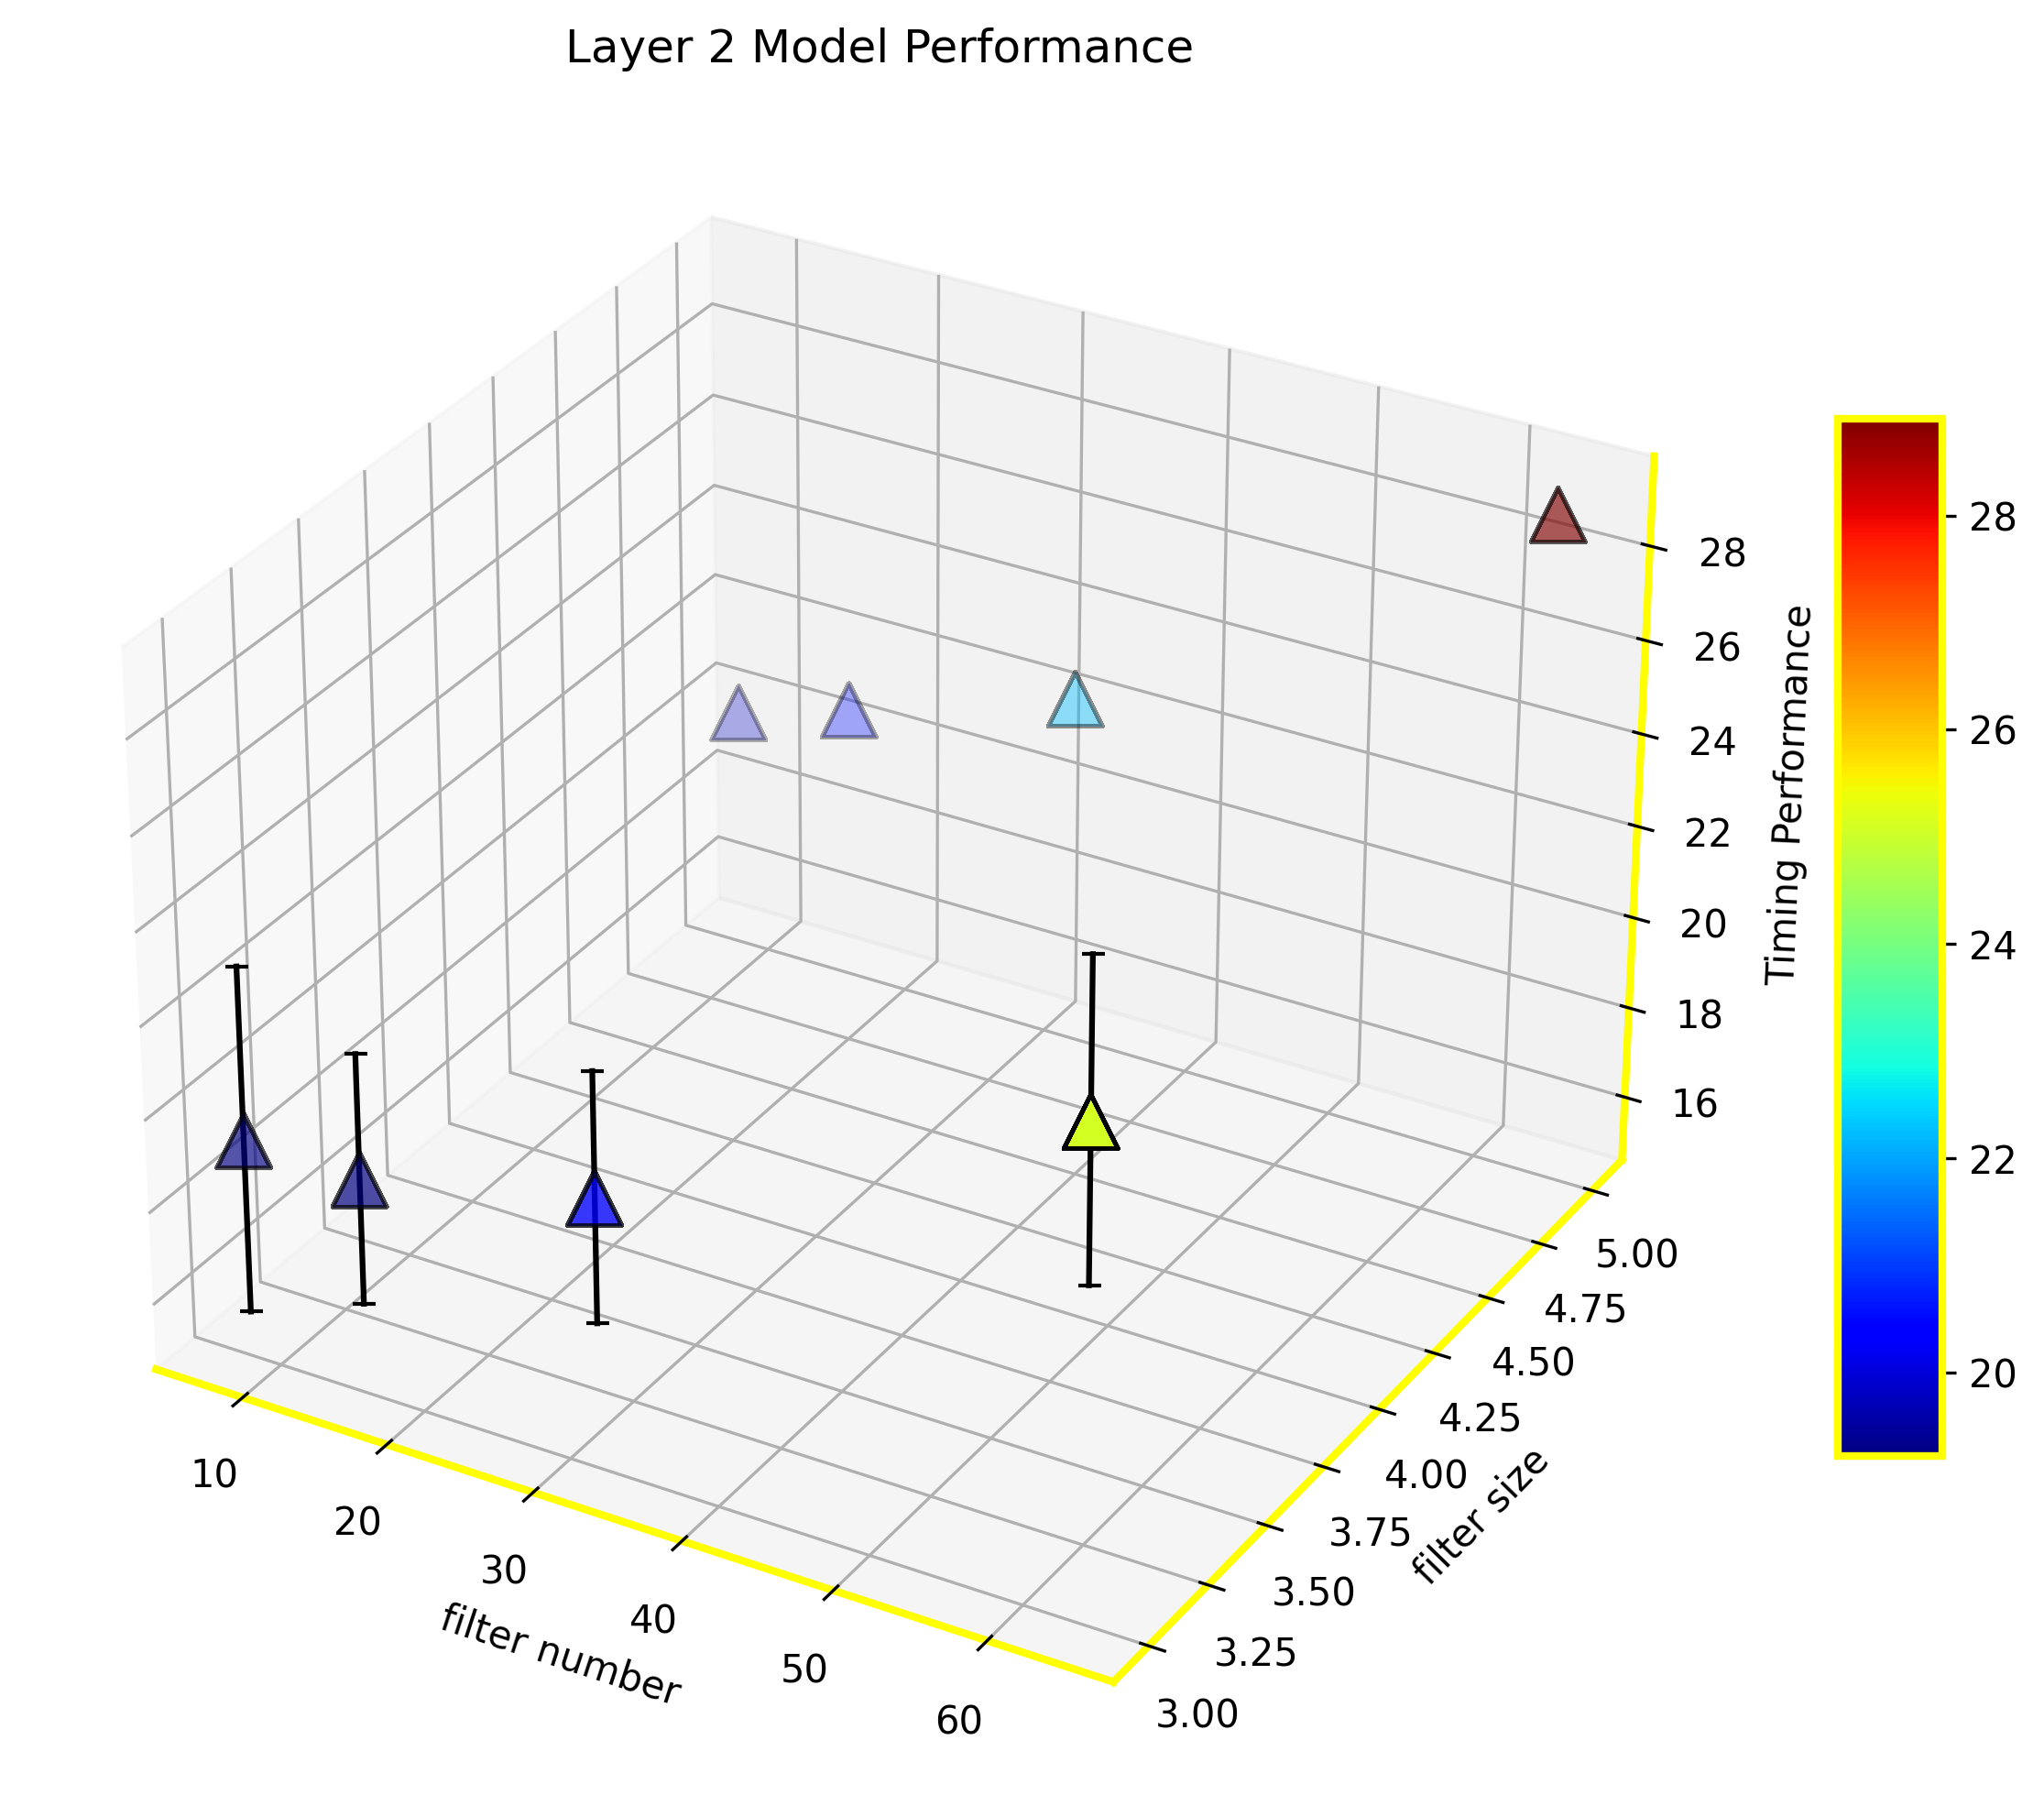

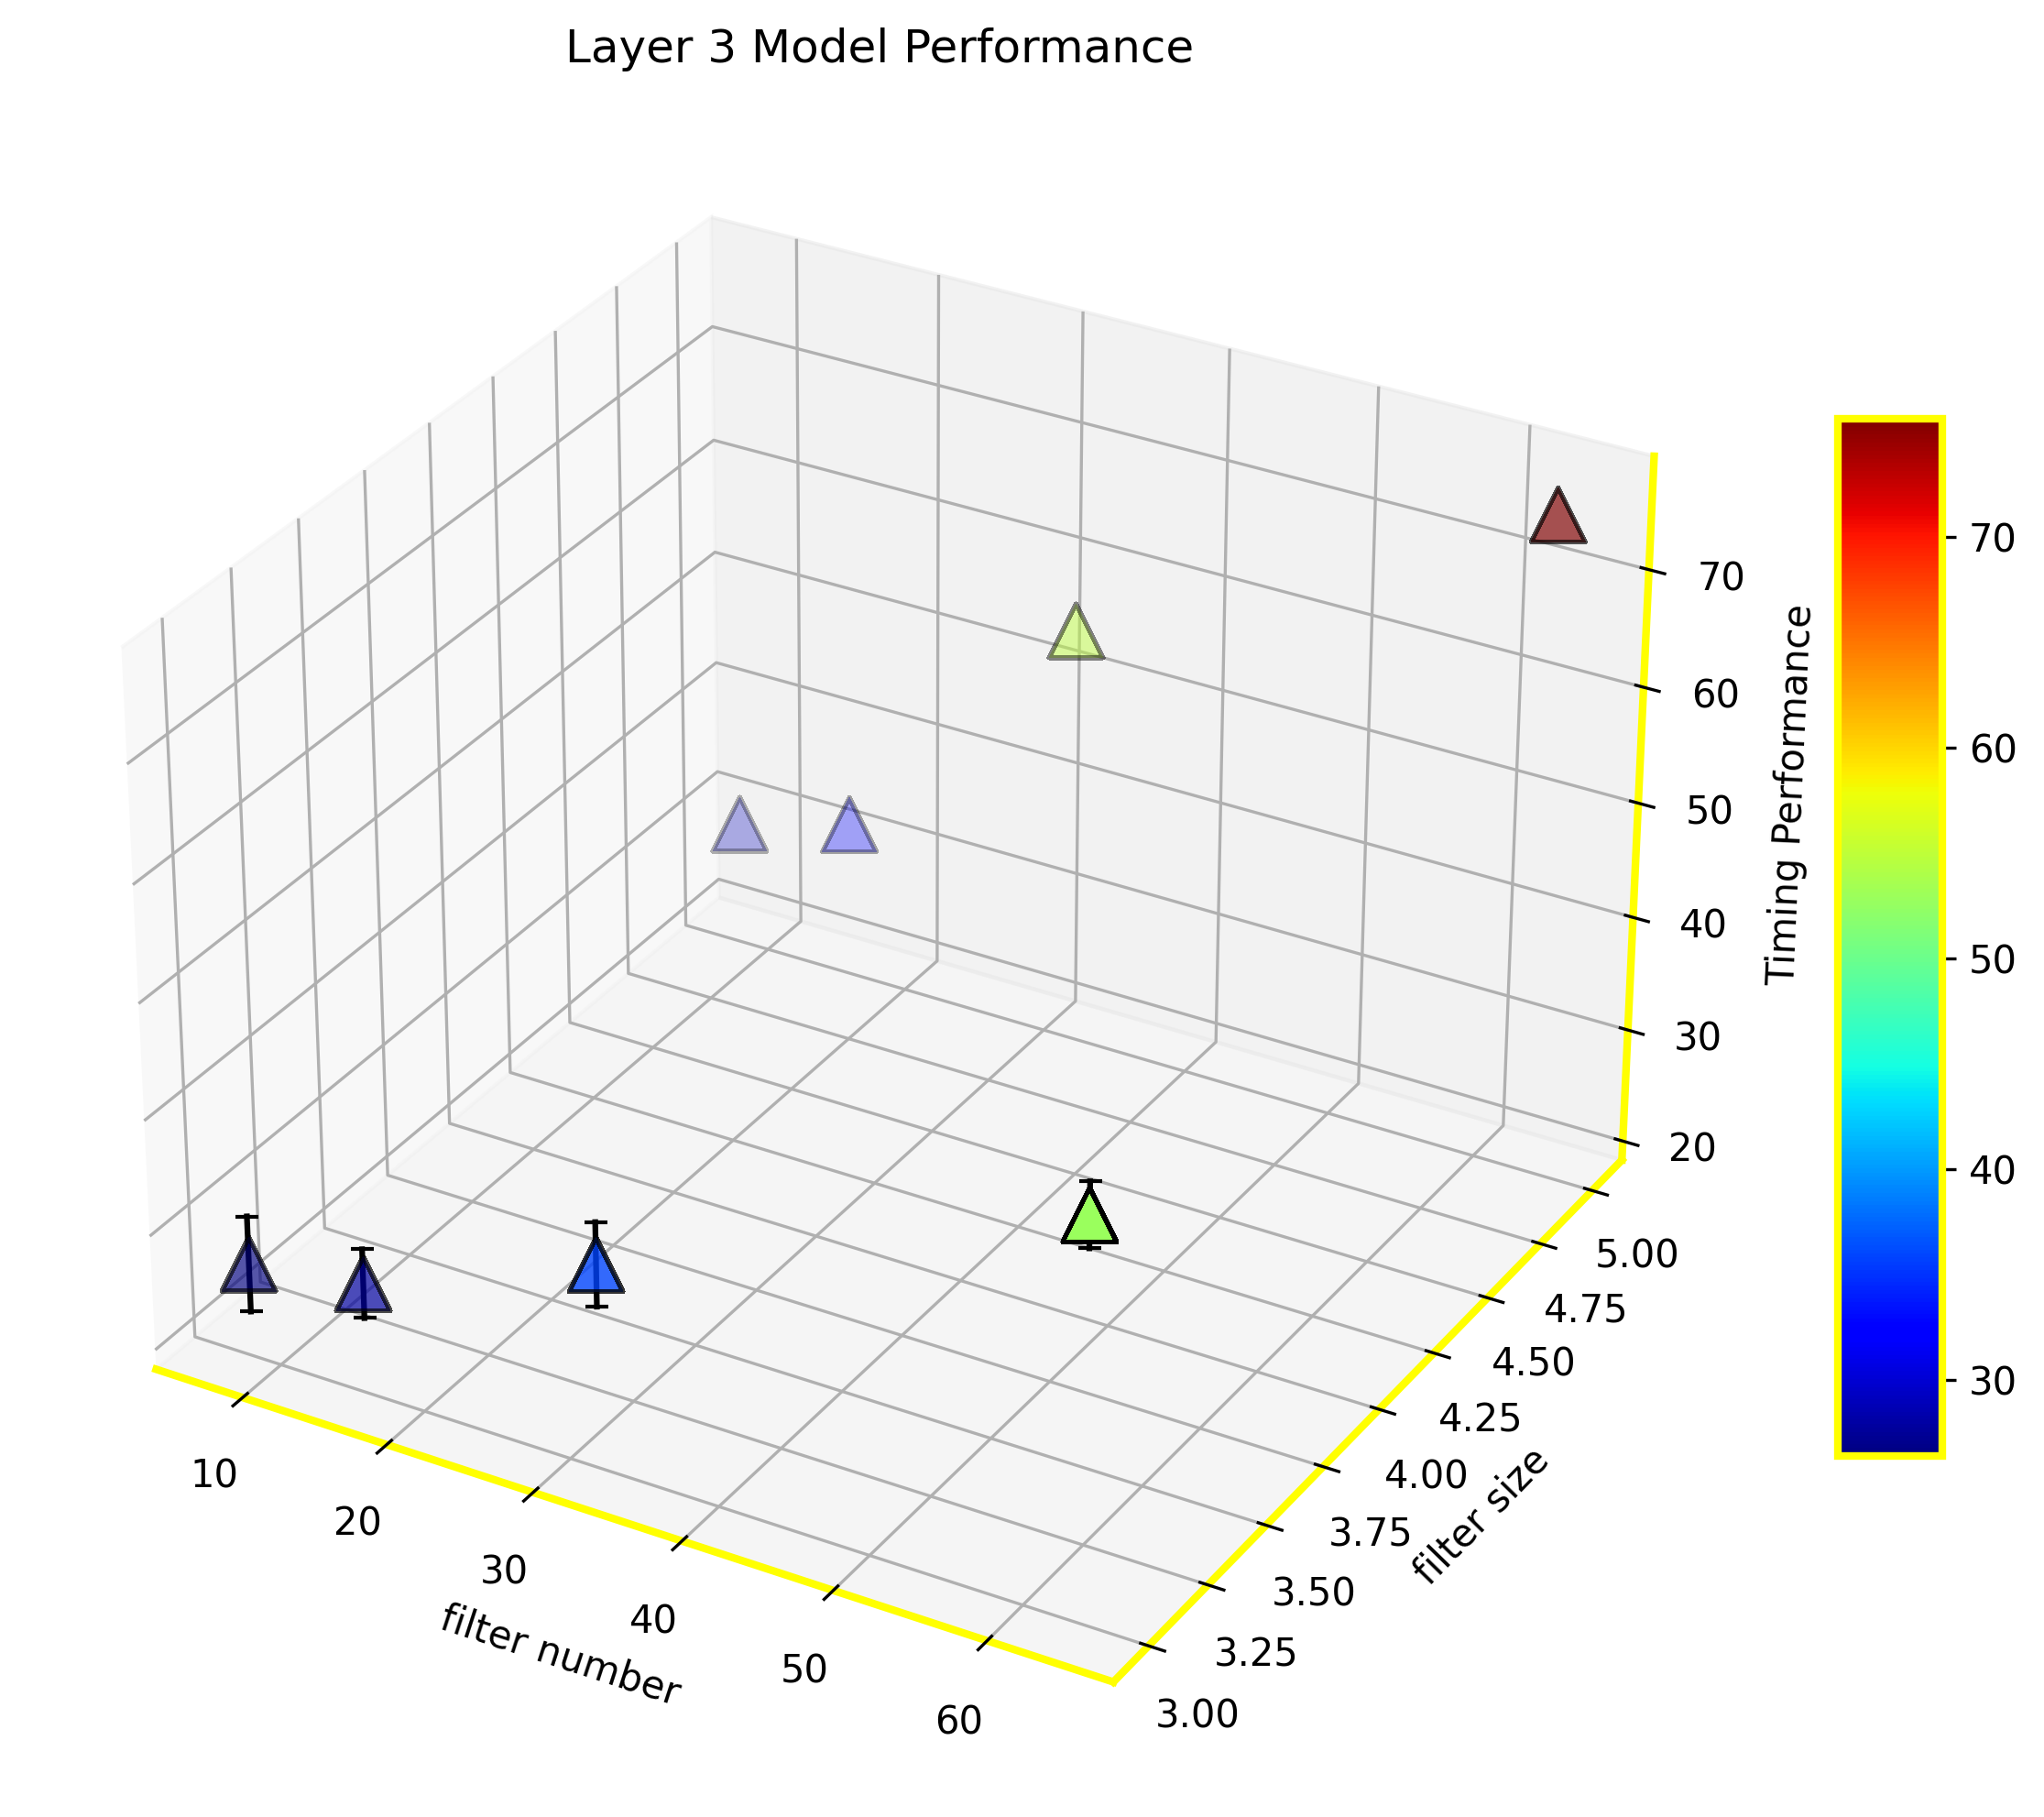

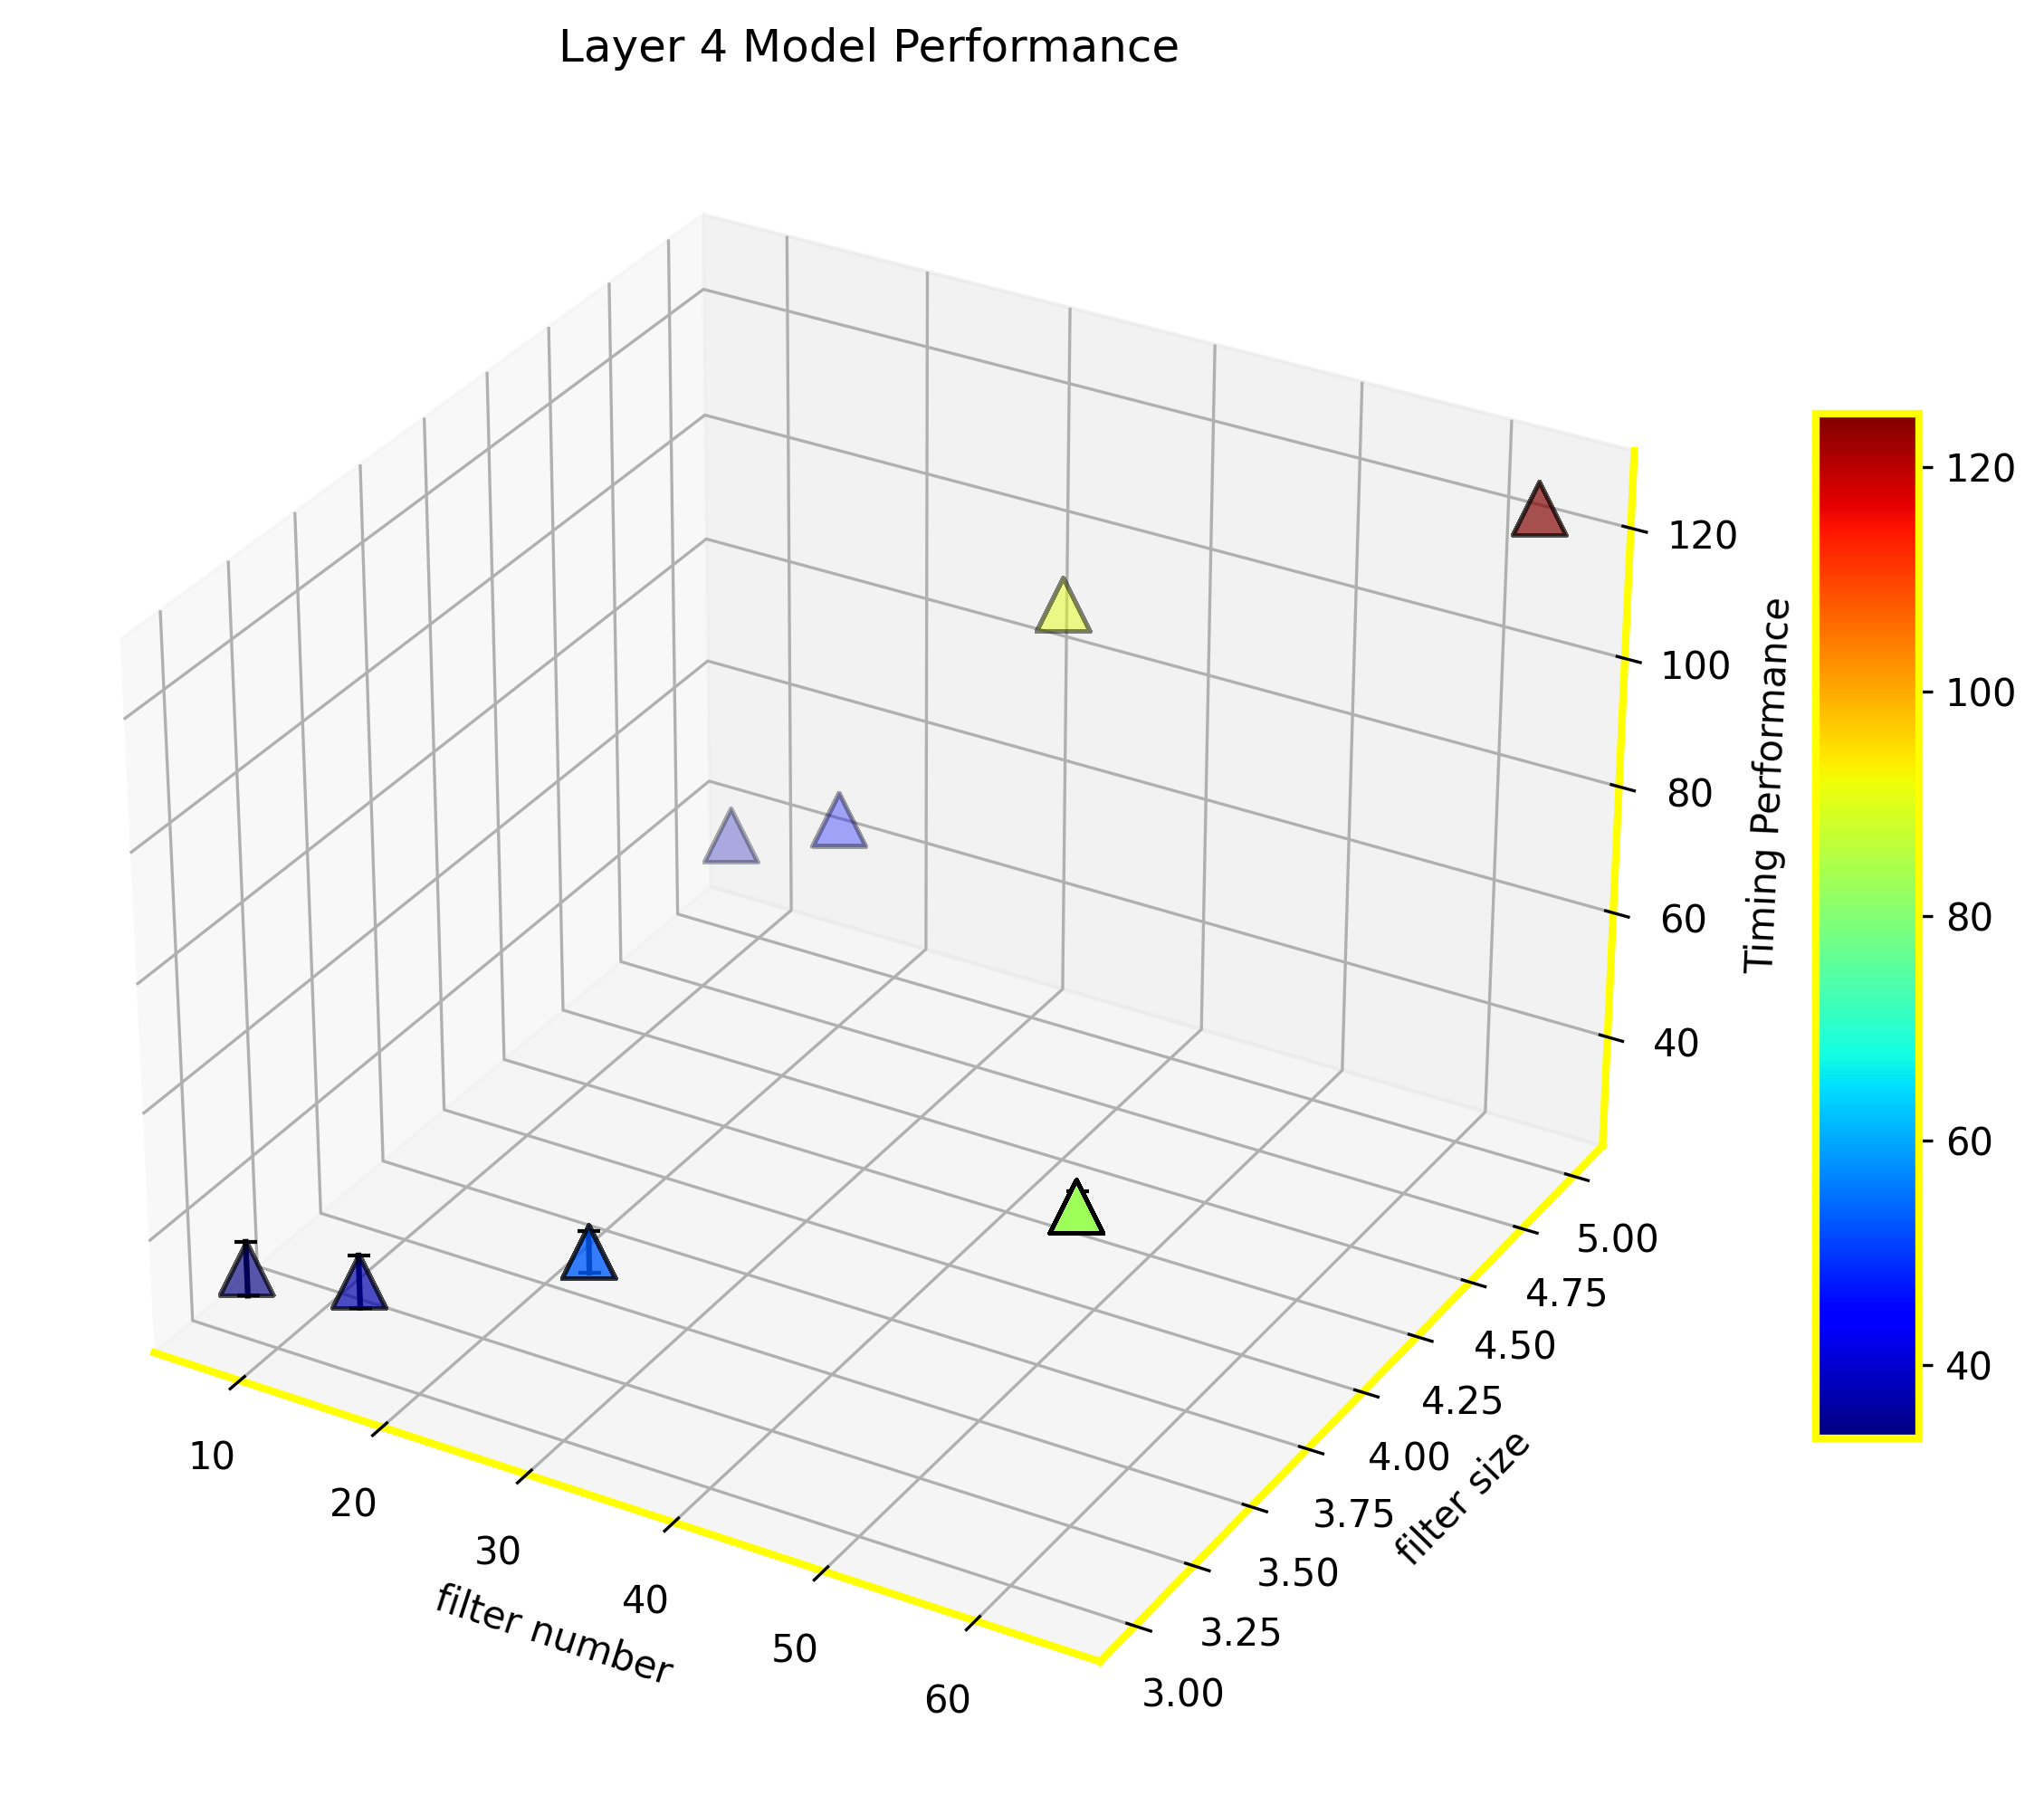

In [117]:
j = 2
for df_ in [dd2_l2, dd2_l3, dd2_l4]:
    #data
    fx = (8, 16, 32, 64)
    fy = (3, 5)
    z = [df_[df_['filter size'] == 3]['mean'],  # Pay attention to the formatting here!
         df_[df_['filter size'] == 5]['mean']]


    x, y = np.meshgrid(fx, fy)


    #error data
    zerror = [df_[df_['filter size'] == 3]['std'],  # Pay attention to the formatting here!
              df_[df_['filter size'] == 5]['std']]



    #plot points
    fig = plt.figure(figsize = (10,10), dpi = 300)
    ax = fig.gca(projection='3d')
    surf=ax.scatter3D(x, y, z,  c=z, cmap="jet", s=200, edgecolors="black", linewidth=1, marker= "^", antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)

    ax.set_xlabel('filter number')
    ax.set_ylabel('filter size')
    ax.set_zlabel('Timing Performance')
    ax.set_title('Layer {} Model Performance'.format(j))
    ax.view_init(30, 300)
    j += 1

    #plot errorbars
    for i in np.arange(0, len(fy)-1):  # Lines were modified here!
        for xval, yval, zval, zerr in zip(x[i], y[i], z[i], zerror[i]):
            ax.plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='k')
    plt.show()